# Introducción
En este proyecto desarrollamos un sistema de clasificación automática para predecir el estado de ánimo (mood) de canciones en base a sus características sonoras. El objetivo es construir modelos de machine learning que, a partir de variables como la danzabilidad, la energía, la valencia, el tempo, entre otras, sean capaces de identificar a qué tipo de mood pertenece una canción.

El flujo general del trabajo se divide en varias etapas:

*  Preprocesamiento de datos: limpiamos el conjunto de datos original y normalizamos sus características mediante StandardScaler para asegurar una correcta interpretación por parte de los modelos.

*  Generación de etiquetas con KMeans: como no contamos con etiquetas de mood en el dataset original, aplicamos un algoritmo de clustering (KMeans) para agrupar las canciones en distintos estados de ánimo. Cada canción recibe una etiqueta basada en el clúster al que pertenece.

*  Clasificación supervisada: con estas nuevas etiquetas, transformamos el problema en uno de clasificación supervisada. Entrenamos y comparamos cuatro modelos distintos:
    *  Random Forest
    *  K-Nearest Neighbors (KNN)
    *  Regresión Logística
    *  Máquinas de Vectores de Soporte (SVM)

Cada modelo es ajustado mediante GridSearchCV para encontrar la mejor combinación de hiperparámetros utilizando validación cruzada. Luego se evalúa su rendimiento sobre un conjunto de prueba mediante métricas como accuracy, classification report y matriz de confusión.

* Evaluación y visualización: finalmente, analizamos los resultados de cada modelo para determinar cuál es más eficaz en la tarea de clasificación. También visualizamos gráficamente los resultados y comparamos las predicciones con las etiquetas reales.

In [109]:
# Imports
import sys
import os

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from kneed import KneeLocator
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import time
import logging
import joblib

# [Alex] Define the paths of the data here?
# [Alex] Add requirements.txt and install all modules

## Análisis de los datos

In [110]:
# Cargar el dataset
in_spotify_dataset = './Source/tracks.csv'

df_tracks = pd.read_csv(in_spotify_dataset)
print(f"{df_tracks.head()}")

                       id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  key  loudness  mode  speechine

Con la función head podemos ver cada una de las columans que forman el dataset. A continuación, se explica la información que obtenemos de cada una de ellas:

* id: Identificador único de cada canción proporcionado por Spotify.
* name: Nombre o título de la canción.
* popularity: Popularidad actual de la canción en Spotify (0 = menos popular, 100 = más popular).
* duration_ms: Duración de la canción en milisegundos.
* explicit: Indica si la canción contiene contenido explícito (1 = explícito, 0 = no explícito).
* artists: Nombre(s) del artista(s) que interpretan la canción.
* id_artists: Identificadores únicos en Spotify de los artistas correspondientes.
* release_date: Fecha en la que se lanzó originalmente la canción (formato YYYY-MM-DD).
* danceability: Qué tan adecuada es una canción para bailar (0.0 = menos bailable, 1.0 = más bailable).
* energy: Energía y nivel de actividad percibido en la canción (0.0 = menos energética, 1.0 = más energética).
* key: Tono o clave musical en la que está compuesta la canción (valores numéricos de 0 a 11 que corresponden a notas musicales).
* loudness: Volumen promedio de la canción en decibelios (dB).
* mode: Modalidad de la canción (0 = menor, 1 = mayor).
* speechiness: Medida de cuánto contenido hablado tiene una canción (0.0 = poca o ninguna, cerca de 1.0 = predominantemente hablada).
* acousticness: Indica qué tan acústica es la canción (0.0 = menos acústica, 1.0 = muy acústica).
* instrumentalness: Indica la probabilidad de que una canción sea instrumental (más cercano a 1.0 significa mayor probabilidad instrumental, 0.0 es típicamente vocal).
* liveness: Indica la probabilidad de que la canción haya sido grabada en vivo (más cercano a 1.0 indica alta probabilidad de que sea en vivo).
* valence: Indica la positividad o felicidad que transmite una canción (0.0 = más triste o negativa, 1.0 = más alegre o positiva).
* tempo: Velocidad o ritmo de la canción medida en BPM (pulsos por minuto).
* time_signature: Número de pulsos por compás en la canción (por ejemplo: 4 indica compás de 4/4).


A continuación, comprobamos el número de columnas y filas que conforman nuestro dataset:

In [111]:

print(f"Shape de df_tracks:\n{df_tracks.shape}")

print(f"Info de df_tracks:\n{df_tracks.info()}")

Shape de df_tracks:
(586672, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  

Podemos ver que el fichero a estudiar tiene 586672 canciones con 20 columnas con la información de cada una.
Para conocer el tipo de dato de cada columna y su nulabilidad utilizamos la función info():


Gracias al resultado anterior, podemos deducir lo siguiente:
* El dataset tiene un total de 586,672 registros (filas).
* Posee 20 columnas.
* La mayoría de columnas están completas, con pocos datos faltantes:
  * Solo la columna "name" tiene valores nulos (71 valores faltantes).
* Los tipos de datos incluyen:
  *  texto: id, name, artists, id_artists, release_date
  *  números enteros: popularity, duration_ms, explicit, key, mode, time_signature
  *  números decimales: danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo
* El dataset utiliza aproximadamente 89.5 MB de memoria


Puesto que el propósito del proyecto es conocer el mood de cada una de las canciones del dataset para poder recomendar al usuario según su estado anímico, es necesario quedarnos exclusivamente con las features que aporten un significado a la variable objetivo (mood). Para ello, vamos a analizar una a una para conocer el listado final de features a utilizar para obtener el mood de cada canción.



Para nuestro proyecto, hemos identificado que uno de los aspectos clave para recomendar canciones según el estado de ánimo es entender cómo las características musicales de las canciones pueden reflejar diferentes emociones. En la música, dos aspectos emocionales son fundamentales para definir el estado de ánimo:

Valencia: Describe si la emoción que transmite la canción es positiva o negativa. Una canción con alta valencia suele ser alegre y optimista, mientras que una canción con baja valencia tiende a ser más triste o melancólica.

Arousal (Excitación): Se refiere a la intensidad de la emoción que genera la canción. Una canción con alta excitación (arousal) suele ser enérgica, vibrante o estimulante, mientras que una canción con baja excitación puede ser más calmada, relajante o suave.

Modelo Dimensional de las emociones
Según investigaciones de psicología y neurociencia, las emociones se pueden entender mejor como un espacio dimensional que abarca dos dimensiones principales: valencia y arousal. Valencia nos dice si la emoción que se experimenta es positiva o negativa, mientras que arousal nos muestra la intensidad o fuerza de esa emoción (Feldman Barrett & Russell, 1999; Lang, Bradley, & Cuthbert, 1997; Russell, 2003). En resumen:

Valencia: Qué tan positiva o negativa es la emoción (alegría vs. tristeza).

Arousal: Qué tan intensa es la emoción (calma vs. excitación).

Con esta base, hemos decidido centrarnos en ciertas características musicales de las canciones que se correlacionan estrechamente con valencia y arousal. Esto nos permite clasificar y recomendar canciones en función del estado de ánimo del usuario.




Características clave para entender el estado de ánimo de una canción:
En nuestra tabla, hemos seleccionado las características musicales que afectan directamente el estado de ánimo de la canción. Estas características fueron elegidas porque están estrechamente relacionadas con la valencia y el arousal de la canción. A continuación, te explico cada una de ellas:




| **Columna**      | **Útil para el mood** | **Razón concreta**                                                                                   |
|------------------|-----------------------|------------------------------------------------------------------------------------------------------|
| **energy**       | ✅                    | Cuantifica la intensidad de la canción, lo que tiene un impacto directo en el **arousal** (emociones intensas).|
| **tempo**        | ✅                    | El ritmo de la canción afecta tanto la **energía** como la intensidad emocional (**arousal**).          |
| **loudness**     | ✅                    | La **intensidad** (volumen) de la canción afecta directamente la percepción de excitación (**arousal**).|
| **danceability** | ✅                    | Qué tan fácil es bailar la canción está relacionado con el **arousal** (canciones bailables suelen ser más energéticas).|
| **valence**      | ✅                    | Describe qué tan **positiva** o **negativa** es la canción, directamente relacionada con el mood general de la canción.|



Explicacion de la tabla :

Energy (Energía): Una canción con más energía tiende a ser más estimulante y dinámica, lo que está relacionado con un mayor nivel de arousal. Cuanta más energía tenga una canción, más intensa será la emoción que evoca. Por ejemplo: pensemo en una cacnión con mucha energía como un café cargadao. Te hace sentir más despierto y con ganas de moverte.

Tempo (Ritmo): El ritmo de la canción influye directamente en el arousal. Una canción rápida o con un ritmo más acelerado genera una mayor excitación, mientras que una canción más lenta puede generar una sensación más tranquila y relajada. Por jemplo: pensemos en una canción con ritmo rápido es como cuando tu corazón late más rápido al ahacer ejercicico. Te llena de energia y emoción. Y una canción lenta es como un abrazo suave, te relaja y te hace sentir tranquilo.

Loudness (Volumen): Las canciones más ruidosas, con mayor volumen, suelen tener un impacto más fuerte emocionalmente, lo que eleva el arousal. Por ejempplo: una canción a todo volumen es como un grifo fuerte. Te impacta y te hace sentir emociones más intensas. Las canciones con mucho volumen 'despiertan' más emociones que las que están mas bajas de volumen.

Danceability (Bailabilidad): Las canciones que son fáciles de bailar suelen tener una energía más alta, lo que también está relacionado con una mayor excitación. Por ejemplo: Las canciones que te hacen mover los pies son como una fiesta. Te dan ganas de bailar y te hacen sentir alegre y con energía. Cuanto más fácil sea bailar una canción, normalmente, más energía contiene.

Valence (Valencia): Finalmente, la valencia es la medida que nos dice si una canción transmite emociones positivas (alegría, felicidad) o negativas (tristeza, melancolía). Esto está directamente ligado al estado de ánimo general de la canción. Por ejemplo: es como el 'estado de ánimo' de la cancioón. Te dice si la canción te hará sentir feliz o triste. Una canción con valence alta te hará sentir alegre, mientras que una con valence baja te hará sentir melancólico.


Con estas features ya podemos hacer la normalización de datos

Esta función clean_normalize_dataset realiza las siguientes tareas:

*  Carga y limpieza: Lee el archivo CSV de entrada (tracks.csv), escoge las columnas que hemos seleccionado (FEATURES) y elimina las filas con valores nulos.

*  Normalización: Ajusta los valores de las caracteristicas de las canciones para que estén dentro de rangos específicos.

*  Cálculo de 'arousal': Creamos una nueva características llamada 'arousal' que mide la excitación emocional de la canción basada en características como la energy, el tempo, loudness y la danceability

A continuación, usamos esta función, y explicamos primero el código paso a paso y observamos los resultados:

El código se encarga de limpiar y normalizar un conjunto de datos en formato CSV, que en nuestro caso es sobre las canciones de Spotify, asegurando que las características de las canciones estén en un rango estándar para que podamos analizarlas de forma coherente. Además, se centra en el cálculo de los características clave para medir el estado ánimo de las canciones: valence(valencia) y arousal (excitación).

1. Carga y limpieza de los datos:
    
    df = pd.read_csv(input_csv)
    Con esta función se carga el archivo CSV que contienen los datos de las canciones en un DataFrame llamada df. Este DataFrame es donde se almacenan los datos en formato de la tabla.

    df = df[old_features].dropna().copy()
    Con esta función toma las columnas relevantes del conjunto de datos(old_features), que incluyen las características 'energy', 'tempo', 'loudness', 'danceability', 'valence'. Luego eliminamos las filas que contienen valores faltantes, somo mantieene los registros con datos completos.

2. Definir los rangos de normalización:
   

    ## Rangos de Normalización

    El diccionario `scale_ranges` define los rangos mínimo y máximo esperados para ciertas características de las canciones. Estos rangos se utilizan para normalizar los datos y asegurar que todas las características estén en la misma escala (0 a 1).

    ```python
    scale_ranges = {
        'tempo': (20, 200),  # Rango típico de BPM en canciones populares
        'loudness': (-60, 0), # Rango de decibelios según la API de Spotify
        'energy': (0, 1),      # Valores normalizados de la API de Spotify
        'danceability': (0, 1) # Valores normalizados de la API de Spotify
    }

    * 'tempo': (20, 200)
        Represeta el ritmo de la canción en pulsaciones por minuto(BPM)
        El rango de 20 a 200 BPM cubre la mayoría de las canciones populares
    * 'loudness' :(-60, 0)
        Representa el volumen de la canción en decibilios (dB)
        Este rango se basa en la documentación de la API de Spotify, que indica que los valores de loudness suelen estar entre -60 y 0 dB.
    * 'energy' : (0,1)
        Representa la energía de la canción, con valores normalizados entre 0 y 1.
        Este rango es proporcionado directamente por la API de Spotify
    * 'danceability': (0,1)
        Representa cuán bailable es una canción, con valores normalizados entre 0 y 1.
        Este rango también es proporcionado por la API de Spotify.

    Estos rangos son esenciales para el proceso de normalización, ya que garantizan que todas las características tengan el mismo peso en el modelo de aprendizaje automático.

3. Ajuste de los valores de fuera de rango 

    data_scaled['tempo'] = data_scaled['tempo'].clip(lower=20, upper=200)
    data_scaled['loudness'] = data_scaled['loudness'].clip(lower=-60, upper=0)
    data_scaled['energy'] = data_scaled['energy'].clip(lower=0, upper=1)
    data_scaled['danceability'] = data_scaled['danceability'].clip(lower=0, upper=1)

    Este bloque de código asegura que los valores ('tempo', 'loudness', 'energy', 'danceability') se ajusten dentro de los rangos esperados para cada una de ellas. Si algún valor se sale de estos rangos, se ajusta automáticamente para quedar dentro de los límites especificados.

    Este paso es importante, porque los datos reales pueden tener valores fuera de los rangos esperador, y con este proceso los recortamos para asegurar que los datos sean consistentes.

4. Normalización de los datos (Escalado Min-Max)

    ```python
        for feature, (min_input, max_input) in scale_ranges.items():
            min_output = 0
            max_output = 1
            data_scaled[feature] = (data_scaled[feature] - min_input) / (max_input - min_input) * (max_output - min_output) + min_output

    Aqui estamos aplicando el proceso de normalización o escalado Min-Max. Esto transfrma los valores de cada características para que siempre estén dentro de un rango estándar de 0 a 1, lo que nos facilita la comparación entre ellas.
    
    Min-Max Scaling: Este método ajusta los valores de cada columna según la fórmula:
    
    Escalado = (Valor - Mínimo del Rango de Entrada) / (Máximo del Rango de Entrada - Mínimo del Rango de Entrada) 
          * (Máximo del Rango de Salida - Mínimo del Rango de Salida) 
          + Mínimo del Rango de Salida
    El resultado de este cálculo será un valor entre 0 y 1 para cada carcaterística.

    Este proceso nos ayuda a que todos los valores estén en la misma escala, lo que es muy importante cuando los estamos comparando o usándolos en un modelo de parendizaje automático,ya que no queremos que las características con rangos más grandes dominen a los que tienen rangos más pequeños.

5. Redondear los valores a 3 decimales 
    ```python 
        data_scaled = data_scaled.round(3)

    Este paso lo hacemos para redondear los valores del DataFrame data_scaled a 3 decimales para facilitar la lectura y manejo de los datos. Al redondear los valores, también moejoramos la precisión de los resultados y evitamos que los valores decimales extremadamentes largos afecten al análisis.

6. Cálculo del 'Arousal' (Excitación) 
    ```python 
        alpha = 0.5  
        beta = 0.25  
        gamma = 0.2  
        delta = 0.05  

        data_scaled['arousal'] = (alpha * data_scaled['energy']) + \
                         (beta * data_scaled['tempo']) + \
                         (gamma * data_scaled['loudness']) + \
                         (delta * data_scaled['danceability'])


    Para calcular el Aurosal usamos la siguiente formula, que toma en cuenta cuatro características de las canciones, explicadas posterioremente.

    Arousal = (α * energy) + (β * tempo) + (γ * loudness) + (δ * danceability)

    donde:
    - α = 0.5 (Energía tiene más influencia), tiene el mayor peso, porque se considera la característica más influyente para medir la excitación de una canción
    - β = 0.25 (Tempo tiene menos influencia que energía), tiene un peso menor, ya que el ritmo también influye, pero no tanto como la energía
    - γ = 0.2 (Loudness tiene una influencia menos significativa), tiene un peso aún más pequeño, ya que el volumen puede influir en como percibimos la excitación, pero no tanto como las dos anteriores
    - δ = 0.05 (Danceability tiene la menor influencia), tiene e peso más bajo, ya que no tiene mucho impacto en la excitación emocional.

    La suma ponderada de estos valores nos da como resultado una puntuación de excitacion(Arousal), que refleja la intensidad emocional de la canción.


7. Redondeo de los valores de Arousal.
    ```python 
        data_scaled = data_scaled.round(3)

    Igual que con las otras caracteríticas, se redondea los valores a 3 decimales para mantener la consistencia en los datos procesados

8. Guardar los datos  finales.
    ```python 
        scaled_df = data_scaled[new_features].dropna().copy()
        scaled_df.to_pickle(scaled_output_pkl)

    Finalmente, seleccionamos solo las columnas que nos interesan, en nuestro caso valence y arousal, y guardamos estos datos procesados en un archico '.pkl'. Este archivo se podrá cargar posteriormente sin tener que repetir todo el proceso de limpieza y normalización. 

9. Imprimir la información sobre el proceso
    ```python 
    print(f"Scaled Data Description:\n{data_scaled.describe()}")
    print(f"Data with Arousal Score Description:\n{data_scaled.describe()}")
    print(f"First few rows of the scaled data:\n{data_scaled.head()}")

    Imprimimos la información descriptiva de los datos en cada paso importante que posteriormente explicaremos, lo que incluye:
        - Descripción general de los datos depues de la normalización
        - Estadisticas clave de los datos procesados, como el valor mínimo, máximo, media,...
        - Los primeros valores de las filas para que podamos revisar rápidamente cómo se ven los datos despúes de la transformación


In [117]:
data_scaled_pkl = './Data/data_scaled.pkl'

# Process dataset
def clean_normalize_dataset(input_csv: str, scaled_output_pkl: str):

    start_time = time.time()
    print(f"Clean and Normalize Dataset")

    # Features
    old_features = ['energy','tempo','loudness','danceability','valence']
    new_features = ['arousal','valence']

    # Load the data and clean it (drop missing values)
    df = pd.read_csv(input_csv)
    print(f"Shape Original: {df.shape}")
    print(f"Missing data before cleanup: {df[old_features].isnull().sum().sum()} entries.")
    df = df[old_features].dropna().copy()
    print(f"Original Data Description:\n{df.describe()}")
    print(f"First few rows of the scaled data:\n{df.head()}")

    # Initialize the data_scaled DataFrame
    data_scaled = df.copy()

    # Define scaling ranges for specific features
    scale_ranges = {
        'tempo': (20, 200),
        'loudness': (-60, 0),
        'energy': (0, 1),
        'danceability': (0, 1)
    }

    # Clip the tempo and loudness values to ensure they stay within the expected ranges
    data_scaled['tempo'] = data_scaled['tempo'].clip(lower=20, upper=200)
    data_scaled['loudness'] = data_scaled['loudness'].clip(lower=-60, upper=0)
    data_scaled['energy'] = data_scaled['energy'].clip(lower=0, upper=1)
    data_scaled['danceability'] = data_scaled['danceability'].clip(lower=0, upper=1)

    # Apply MinMax scaling for each feature
    for feature, (min_input, max_input) in scale_ranges.items():
        min_output = 0
        max_output = 1
        data_scaled[feature] = (data_scaled[feature] - min_input) / (max_input - min_input) * (max_output - min_output) + min_output

    # Round the values to 3 decimal places
    data_scaled = data_scaled.round(3)

    # Log the description after scaling
    print(f"Scaled Data Description:\n{data_scaled.describe()}")

    # Define the weights for the features
    alpha = 0.5  # Energy has more influence on arousal
    beta = 0.25  # Tempo is still important, but less than energy
    gamma = 0.2  # Loudness is less important, but still relevant
    delta = 0.05  # Danceability plays the least role in arousal
    
    # Calculate the arousal score (weighted sum of selected features)
    data_scaled['arousal'] = (alpha * data_scaled['energy']) + \
                             (beta * data_scaled['tempo']) + \
                             (gamma * data_scaled['loudness']) + \
                             (delta * data_scaled['danceability'])
    
    # Round the values for arousal
    data_scaled = data_scaled.round(3)

    # Log the description after calculating arousal
    print(f"Data with Arousal Score Description:\n{data_scaled.describe()}")
    print(f"First few rows of the scaled data:\n{data_scaled.head()}")

    # Select the relevant columns (valence and arousal)
    scaled_df = data_scaled[new_features].dropna().copy()
    print(f"Shape Save: {df.shape}")

    # Save the cleaned and scaled DataFrame to a pickle file
    scaled_df.to_pickle(scaled_output_pkl)

    print(f"Completed in {time.time() - start_time:.2f} seconds")

clean_normalize_dataset(in_spotify_dataset, data_scaled_pkl)

Clean and Normalize Dataset
Shape Original: (586672, 20)
Missing data before cleanup: 0 entries.
Original Data Description:
              energy          tempo       loudness   danceability  \
count  586672.000000  586672.000000  586672.000000  586672.000000   
mean        0.542036     118.464857     -10.206067       0.563594   
std         0.251923      29.764108       5.089328       0.166103   
min         0.000000       0.000000     -60.000000       0.000000   
25%         0.343000      95.600000     -12.891000       0.453000   
50%         0.549000     117.384000      -9.243000       0.577000   
75%         0.748000     136.321000      -6.482000       0.686000   
max         1.000000     246.381000       5.376000       0.991000   

             valence  
count  586672.000000  
mean        0.552292  
std         0.257671  
min         0.000000  
25%         0.346000  
50%         0.564000  
75%         0.769000  
max         1.000000  
First few rows of the scaled data:
   energy   

Exlipación de los datos obtenidos:

1. Shape Original: (586672, 20)
    El conjunto de datos originales tienen 586672 filas (canciones) y 20 columnas (caracteríticas relacionadas con esas canciones)

2. Missing data before cleanup: 0 entries
    Nos indica que no falata ningún dato en las columnas seleccionadas para trabajar, es decir, todas las canciones tienen valores completos en las características que estamos analizando.

3. Original Data Description
    Se muestra un resumen de las características numéricas de los datos originales para cada una de las columnas seleccionadas:
    
    ## Descripción de Datos Originales

    - **'energy' (energía):** Es una medida de cuánta energía tiene la canción.
        - Mean (Promedio): 0.542, lo que indica que las canciones tienen una cantidad moderada de energía.
        - Min (Mínimo): 0, lo que indica que hay canciones con muy poca energía.
        - Max (Máximo): 1, lo que indica que hay canciones con mucha energía.
        - std (Desviación estándar): 0.25, lo que indica que las canciones tienen una variabilidad moderada en términos de energía.

    - **'tempo' (ritmo):** Es la velocidad de la canción, medida en pulsos por minuto (BPM).
        - Mean (Promedio): 118.46 BPM, lo que indica que la mayoría de las canciones tienen un ritmo moderado (alrededor de 118 BPM).
        - Min (Mínimo): 0 BPM, lo que podría indicar que hay canciones con un ritmo nulo o que no se han registrado bien.
        - Max (Máximo): 246.38 BPM, lo que indica que hay canciones con un ritmo muy rápido.
        - std (Desviación estándar): 29.76 BPM, lo que indica que la variabilidad del ritmo entre las canciones es bastante alta.

    - **'loudness' (volumen):** Es el volumen de la canción en decibelios (dB).
        - Mean (Promedio): -10.21 dB, lo que indica que las canciones tienen un volumen promedio moderado.
        - Min (Mínimo): -60 dB, que es el volumen más bajo posible (lo que puede indicar canciones muy suaves o con valores anormales).
        - Max (Máximo): 5.38 dB, lo que indica que hay canciones con un volumen significativamente alto.
        - std (Desviación estándar): 5.08 dB, lo que indica una variabilidad considerable en el volumen entre las canciones.

    - **'danceability' (bailabilidad):** Mide cuán bailable es una canción (cuánto incita a moverse).
        - Mean (Promedio): 0.56, lo que indica que, en promedio, las canciones son moderadamente bailables.
        - Min (Mínimo): 0, lo que indica que algunas canciones no son nada bailables.
        - Max (Máximo): 0.99, lo que indica que algunas canciones son muy bailables.
        - std (Desviación estándar): 0.16, lo que indica que la variabilidad de la bailabilidad entre las canciones es baja.

    - **'valence' (valencia):** Mide el "estado de ánimo" de la canción, desde negativo (baja valencia) hasta positivo (alta valencia).
        - Mean (Promedio): 0.552, lo que indica que, en promedio, las canciones tienen un estado de ánimo ligeramente positivo.
        - Min (Mínimo): 0, lo que indica canciones con un estado de ánimo negativo.
        - Max (Máximo): 1, lo que indica canciones con un estado de ánimo muy positivo.
        - std (Desviación estándar): 0.26, lo que indica que la variabilidad del estado de ánimo entre las canciones es moderada.

4. First few rows of the scaled data:
    
    Aquí se mostramos las primeras filas de los datos después de ser normalizados. Los valores han sido ajustados para estar en un rango de 0 a 1. Esto lo hacemos para que todas las características sean más comprables entre sí y esteén en la misma escala.

5. Shape Save: (586672, 5)

    Esto nos índica , que después de procesar los datos, ahora tenemos 586672 filas (canciones) y 5 filas (que son las 5 columnas importantes para nuestro análisis posterior)



# Intentar entender cual es el numero de clusters ideal

Con el siguiente código, tenemos como objetivo encontrar el número ideal de clusters(agrupaciones) en nuestros datos de canciones de Spotify. Para ellos utilizamos el algoritmo K-Means y evalúa diferentes números de clusters usando varias métricas.

1. Carga de Datos:

    data_scaled_for_kmeans = joblib.load(data_scaled_pkl)

    Aquí cargamos los datos normalizados que preparamos anteriormente.

2. Preparacion de variables

    num_rows, num_columns = data_scaled_for_kmeans.shape
    sample_sil = round((num_rows-1)*0.05) #5% Dataset
    wcss_results = []
    sil_results = []
    ch_results = []
    db_results = []
    k_range = range(2, 17)

    Obtenemos el número de filas y columnas de los datos
    Calculamos un tamaño de muestra para la métrica Silhouette (usando el 5% de los datos para acelerar el proceso).
        Métrica Silhoutte, mide qué tan bien se han agrupado los datos en clústeres.
    Inicializamos las listas vacías para almacenar los resultados de las métricas(WCSS, Silhouette, Calinski-Harabasz, Davies-Bouldin)
    Definimos el rango de números de clusters que vamos a probar (2 a 16)

3. Bucle para aplicar K-Means y evaluar los resultados:
    ```python
        for k in k_range:
            print(f"\nRunning K-Means for k={k}")
            start_time = time.time()

            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit_predict(data_scaled_for_kmeans)
            
    Para cada valor de K, el código ejecutal el algoritmo de K-Means, asignado k clusters. El fit_predict asigna las etiquetas de cluster a cada puntoo de datos.

4. Cáculo de las métricas de evaluzación:

    El código calcula las cuatros métricas para evaluar la calidad de los clusters generados por K-Means:
        - WCSS(Within-Cluster Sum of Squares): Mide la dispersión dentro de cada cluster. Un valor más bajo es mejor.
            wcss_results.append(kmeans.inertia_)
        - Silhouette Score: Evalúa la consistencia interna de los clusters. Un valor cercano a 1 es excelente, mientras que un valor cercano a -1 indica que los puntos podrían estar en el cluster equivocado.
            sil_score = silhouette_score(data_scaled_for_kmeans, kmeans.labels_, metric='euclidean', sample_size=sample_sil, random_state=42, n_jobs=-1)
            sil_results.append(sil_score)
        - Calinski-Harabasz Score: Mide la dispersión entre los clusters. Un valor más alto indica una mejor separación entre clusters.
            ch_score = calinski_harabasz_score(data_scaled_for_kmeans, kmeans.labels_)
            ch_results.append(ch_score)
        - Davies-Bouldin Score: Mide la relación entre la dispersión dentro de los clusters y la separación entre ellos. Un valor más bajo indica una mejor calidad del clustering.
            db_score = davies_bouldin_score(data_scaled_for_kmeans, kmeans.labels_)
            db_results.append(db_score)


5. Almacenar la etiqueta del cluster ('mood') para cada cancion:
    data_scaled_for_kmeans['mood'] = kmeans.labels_
    
    Aquí agregamos una nueva columna llamada 'mood' que contienen el número de cluster al que pertence cada canción. Esto nos ayuda a visualizar cómo se agrupan las canciones segun sus caracteríticas.

6. Gráficos y visualizaciones de los clusters:
    Después de realizar el K-Means, creamos varios gráficos para entender mejor los resultados:

    - Heatmap de Centros de Clusters: Muestra los valores promedio de cada característica en cada cluster, lo que nos ayuda a ver cómo se agrupan las canciones
    - Clusters en Espacio PCA: Visualiza los clusters en un espacio bidimensional reducido usando PCA (Principal Component Analysis).
    - Heatmap de Correlación PCA: Muestra la correlación entre los componentes principales del PCA y las características originales.
 
7. Imprimimos el tiempo de ejecución para cada valor de k

8. Resultados finales de las métricas calculadas las almacenamos para cada número de clusters en un DataFrame. Esto permite comparar fácilmente los resultados y seleccionar el número de clusters ideal

    results_kmeans = pd.DataFrame({
    'k': list(k_range),
    'WCSS': wcss_results,
    'Silhouette Score': sil_results,
    'Calinski-Harabasz': ch_results,
    'Davies-Bouldin': db_results
})
    Los resultados mostradsos en e DataFrame results_kmeans nos permitirá ver cómo varían las métricas para diferentes valores de K. Normalmente, el número óptimo de clusters es el que tiene:

        - El menor WCSS, lo que indica que los clusters están más compactos.
        - El mayor Silhouette Score, lo que indica que los clusters están bien definidos.
        - El mayor Calinski-Harabasz Score, que indica que los clusters están bien separados.
        - El menor Davies-Bouldin Score, lo que indica que los clusters están más separados.

    A partir de aquí podremos elegir el número de clusters que mejor se adapte a nuestros datos.


In [ ]:
data_scaled_for_kmeans = joblib.load(data_scaled_pkl)

num_rows, num_columns = data_scaled_for_kmeans.shape
sample_sil = round((num_rows-1)*0.05) #5% Dataset

wcss_results = []
sil_results = []
ch_results = []
db_results = []

k_range = range(2, 17)
print(f"Running Kmeans k = {list(k_range)} Clusters")
for k in k_range:
    print(f"\nRunning K-Means for k={k}")
    start_time = time.time()

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit_predict(data_scaled_for_kmeans)

    wcss_results.append(kmeans.inertia_)
    sil_score = silhouette_score(
        data_scaled_for_kmeans,
        kmeans.labels_,
        metric='euclidean',
        sample_size=sample_sil, 
        random_state=42,
        n_jobs=-1
    )
    sil_results.append(sil_score)
    ch_score = calinski_harabasz_score(data_scaled_for_kmeans, kmeans.labels_)
    ch_results.append(ch_score)
    db_score = davies_bouldin_score(data_scaled_for_kmeans, kmeans.labels_)
    db_results.append(db_score)

    data_scaled_for_kmeans['mood'] = kmeans.labels_

    # 1. Plotting the heatmap of the clusters first (based on mood)
    plt.figure(figsize=(10, 7))
    sns.heatmap(data_scaled_for_kmeans.groupby('mood').mean().T, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Heatmap of Cluster Centers')
    plt.ylabel('Features')
    plt.xlabel('Cluster')
    plt.show()

    # 2. Plotting the clusters in PCA space (after the heatmap)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_scaled_for_kmeans[['arousal','valence']])
    plt.figure(figsize=(10, 7))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=data_scaled_for_kmeans['mood'], cmap='viridis')
    plt.title('Clusters in PCA Space')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.axhline(0, color='r', linewidth=2)
    plt.axvline(0, color='r', linewidth=2)
    plt.colorbar(label='Mood')
    plt.show()

    # 3. Plotting the heatmap of the correlation between PCA components and features
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df = pd.concat([pca_df, data_scaled_for_kmeans], axis=1)
    correlation_matrix = pca_df.corr()
    plt.figure(figsize=(10, 7))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation between PCA Components and Features")
    plt.show()

    print(f"Completed K-Means for k={k} in {time.time() - start_time:.2f} seconds\n")

# Print the results
results_kmeans = pd.DataFrame({
    'k': list(k_range),
    'WCSS': wcss_results,
    'Silhouette Score': sil_results,
    'Calinski-Harabasz': ch_results,
    'Davies-Bouldin': db_results
})

Running Kmeans k = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] Clusters

### Running K-Means for k=2
# "Heatmap of Cluster Centers"
Clúster 0:

Arousal: 0.66 (relativamente alto)
Valence: 0.75 (muy alto)
Interpretación: El clúster 0 representa canciones con alta excitación (alta energía/intensidad) y muy alta valencia (estado de ánimo positivo). Estas podrían describirse como canciones enérgicas, alegres y optimistas.

Clúster 1:

Arousal: 0.53 (moderado)
Valence: 0.32 (bajo)
Interpretación: El clúster 1 representa canciones con excitación moderada y baja valencia (estado de ánimo negativo). Estas podrían describirse como canciones más tranquilas, tristes o melancólicas.



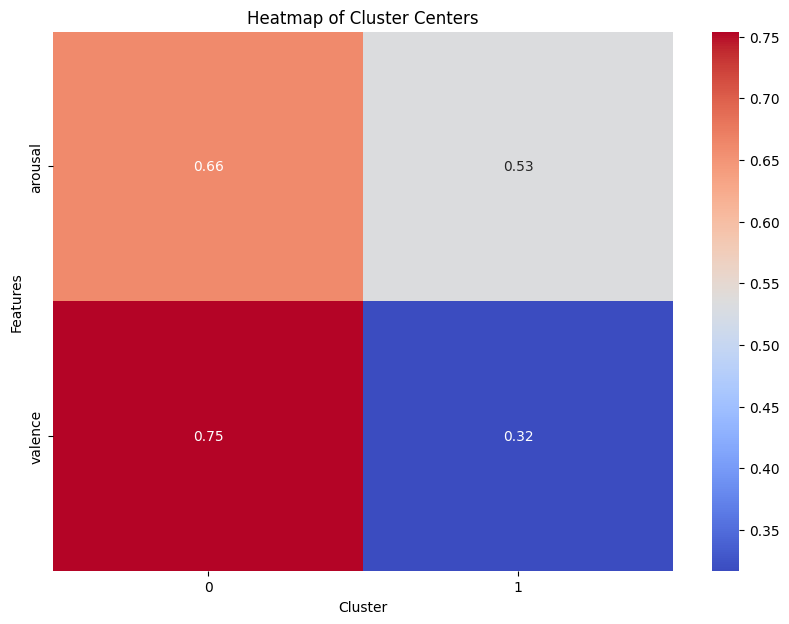
v

# "Clusters in PCA Space" 
Esto nos indica que los datos han sido reducidos a dos dimensiones usando Análisis de Componentes Principales (PCA) y los puntos están coloreados según los clústeres identificados por K-Means.
Ejes:
Eje X (PCA Component 1): El primer componente principal, que representa la dirección de máxima varianza en los datos originales.
Eje Y (PCA Component 2): El segundo componente principal, que representa la segunda dirección de máxima varianza.
Puntos de Datos: Cada punto representa una canción en el conjunto de datos.
Color de los Puntos: El color de cada punto indica el clúster al que pertenece la canción, según lo asignado por K-Means. La barra de color a la derecha muestra la escala de colores correspondiente a los clústeres.
Líneas Rojas: Las líneas rojas que se cruzan en el origen (0,0) dividen el gráfico en cuatro cuadrantes.
Análisis

Separación de Clústeres: El gráfico muestra una clara separación de los datos en dos clústeres distintos. Los puntos amarillos están agrupados a la izquierda, mientras que los puntos morados están agrupados a la derecha. Esto indica que K-Means ha logrado separar eficazmente las canciones en dos grupos basados en las características de arousal y valence.
PCA: PCA ha transformado los datos originales a un nuevo espacio bidimensional donde la separación de los clústeres es más evidente. El Componente Principal 1 parece ser la característica más importante para distinguir entre los dos clústeres.
Interpretación de los Clústeres:
Clúster Amarillo (Izquierda): Este clúster podría representar canciones con alta valencia (positividad) y alta excitación (arousal).
Clúster Morado (Derecha): Este clúster podría representar canciones con baja valencia (negatividad) y baja excitación (arousal).

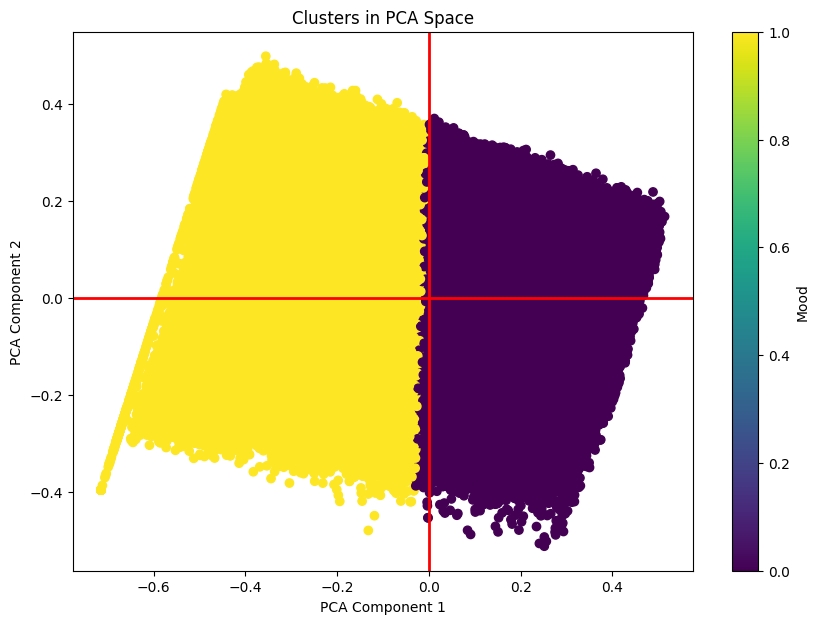


# "Correlation between PCA Components and Features"
Esto nos indica que estamos viendo la correlación entre los componentes principales (PC1 y PC2) obtenidos del Análisis de Componentes Principales (PCA) y las características originales (arousal, valence, mood).
Ejes:
Eje X: PC1, PC2, arousal, valence, mood.
Eje Y: PC1, PC2, arousal, valence, mood.
Escala de Color: La escala de color representa la fuerza y dirección de la correlación.
Rojo: Correlación positiva fuerte.
Azul: Correlación negativa fuerte.
Blanco/Gris: Correlación débil o nula.


Correlación entre Componentes PCA y Características Originales:
PC1 y valence: Correlación positiva fuerte (0.99). Esto indica que el Componente Principal 1 está fuertemente relacionado con la valencia.
PC1 y arousal: Correlación positiva moderada (0.54). Esto indica que el Componente Principal 1 también está relacionado con el arousal, pero en menor medida que con la valencia.
PC2 y arousal: Correlación positiva fuerte (0.84). Esto indica que el Componente Principal 2 está fuertemente relacionado con el arousal.
PC2 y valence: Correlación negativa moderada (-0.17). Esto indica que el Componente Principal 2 tiene una relación negativa débil con la valencia.
Correlación entre Características Originales:
arousal y valence: Correlación positiva moderada (0.39). Esto indica que existe una relación positiva entre el arousal y la valencia, pero no es muy fuerte.
Correlación con "mood":
PC1 y mood: Correlación negativa fuerte (-0.85). Esto indica que el Componente Principal 1 está fuertemente relacionado con el clúster asignado por K-Means (mood).
valence y mood: Correlación negativa fuerte (-0.85). Esto indica que la valencia está fuertemente relacionada con el clúster asignado por K-Means (mood).
arousal y mood: Correlación negativa moderada (-0.41). Esto indica que el arousal tiene una relación negativa con el clúster asignado por K-Means (mood).

La tabla nos explica los siguiente:
Importancia de PC1: El Componente Principal 1 está fuertemente relacionado con la valencia y el clúster asignado por K-Means (mood), lo que sugiere que la valencia es una característica importante para distinguir entre los clústeres.
Importancia de PC2: El Componente Principal 2 está fuertemente relacionado con el arousal, lo que sugiere que el arousal también es una característica importante para distinguir entre los clústeres.
Relación entre arousal y valence: Existe una relación positiva entre el arousal y la valencia, pero no es muy fuerte.


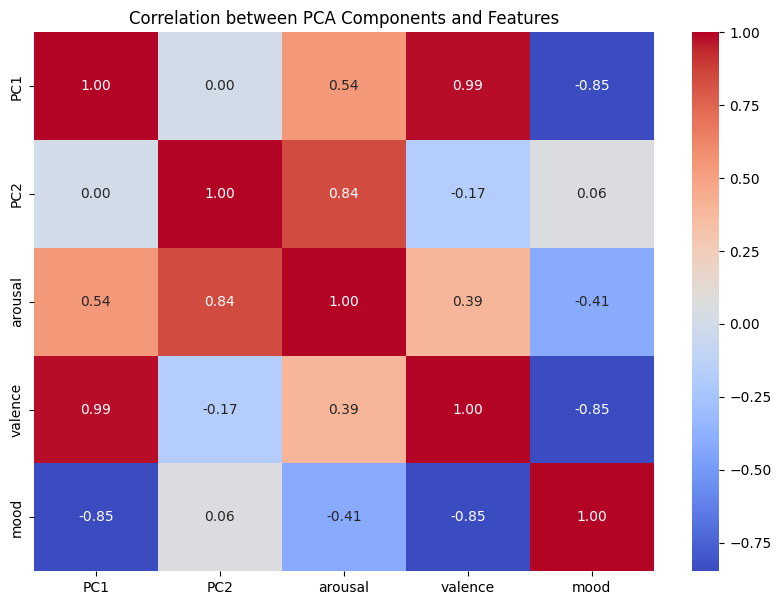

### Running K-Means for k=3
# "Heatmap of Cluster Centers"
Interpretación del Heatmap:

Nos muestra claramente cómo los clusters se difernecian en términos de valencia y arousal
1. Cluster 0,
    Arousal: 0.67 (relativamente alta)
    Valence: 0.83 ( muy alta)
    
    Interpretación: El cluster 0, representa canciones con alta valencia, lo que nos sugiere que las canciones en este grupo tienden a ser alegres y positivas. Además el arousal relativamente alto indica que estas canciones también tiene un nivel de energía considerable, aunque no extremo. Podríamos decir que son canciones animadas y opmistas, ideales para levantar el ánimo.

2. Cluster 1,
    Arousal: 0.47 (bajo)
    Valence: 0.23 (muy bajo)

    Interpretación: El cluster 1, se caracteriza por canciones con una valencia muy baja, lo que implica que predominan las emociones negativas o tristes. El bajo arousal refuerza esta interpretación, sugiriendo que estas canciones son más bien calmadas y melancólicas. Podriamos decir que son canciones que inducen a la refexión de sentimientos de tristeza.

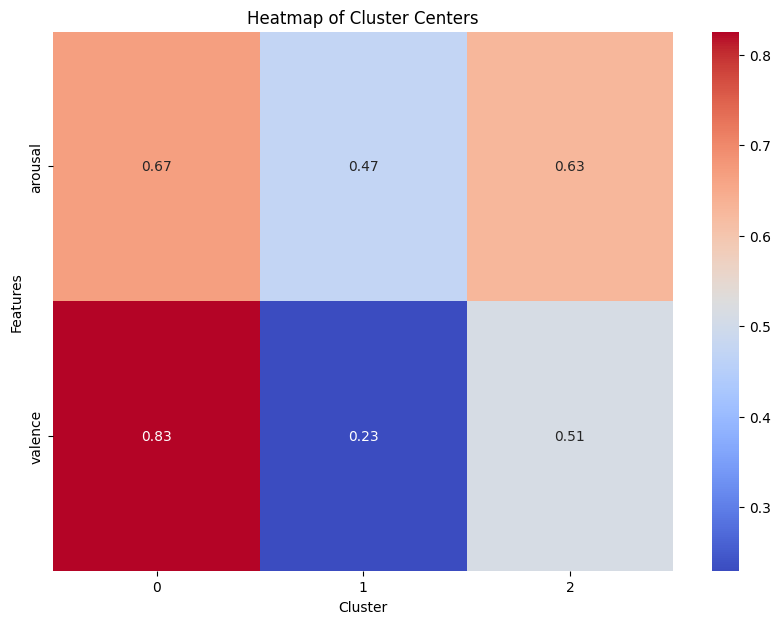

# "Clusters in PCA Space" 
En el siguiente gráfico de dispersión se muestra cómo se agrupan las canciones en un espacio bidimensional después de aplicar PCA. Los puntos están coloreados según los clústeres identicados por el algortimo K-Means, en este caso K=3.

Eje X (PCA Comoponent 1): El primer componente principal, que captura la mayor parte de la varianza de los datos originales.
Eje Y (PCA Cmponenet 2): El segundo componente principal, que captura la ssegunda mayor cantidad de varianza.

Puntos de Datos:
Cada punto representa una canción en el conjunto de datos.
Color de los Puntos: El colo de cada punto indica a que clúster pertence la canción, según la asignación de K-Means. La barra de color a la derecha nos muestra la escala de colores correspondiente a los clústeres.

Análisis:
El gráfico nos muestra una separación clara de los datos en tres clústeres distintos. Los puntos forman tres grupos visualmnete diferenciados donde la separación de los clústeres es más evidentes. Los Componentes Principales 1 y 2 parecen ser efectivos para distinguir entre los grupos,

Interpretación de los Clústeres:
Verde: Este clúster podría representar las caciones con valores bajos del Comonentes Principal 1.
Amarillo: Este clúster podría representar canciones con valores intermedios en ambos componentes principales.
Morado: Este clúster podría representar canciones con valores altos en el Componente Principal 1.

La barra lateral 'Mood', nos indica que los colores utilizados en los puntos del gráfico, indican el estado de ánimo de cada una de las canciones, por lo tanto, el cluster morado, tiene un mood más cerca al 0, y el amarillo tiene un mood cercano al 2.


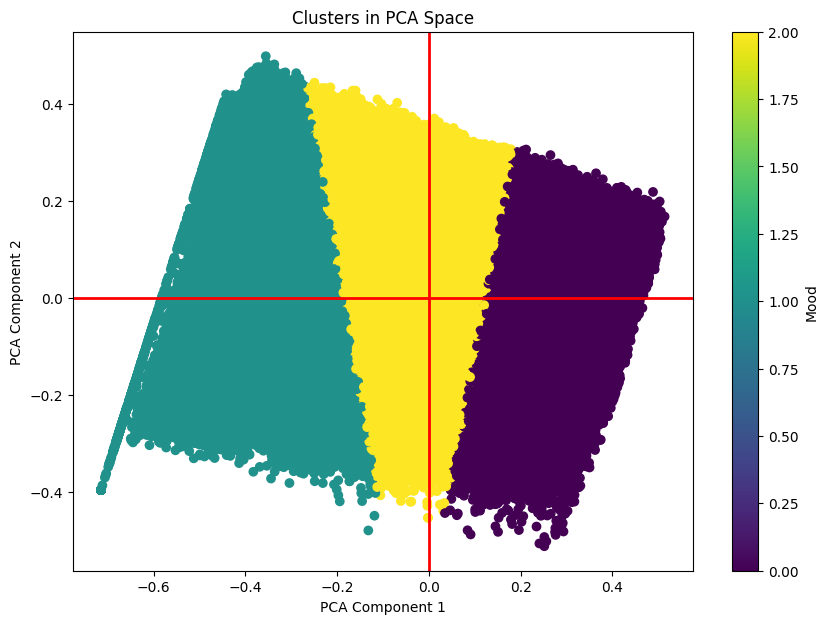

# "Correlation between PCA Components and Features"
En este gráfico mostramos la correlación entre los comoponentes rincipales (PC1 y PC2) obtenidos del PCA y las caracteríticas originales (aurosal, valence, mood)

Eje X: PC1, PC2, arousal, valence, mood.
Eje Y: PC1, PC2, arousal, valence, mood.

La escala de color nos representa la fuerza y dirección de correlación.
    Rojo: positiva
    Azúl: negativa
    Blanco/Gris: débil o nula.

Correlacción entre los Comoponetes PCA y las Caracáteristicas Originales:
    PC1 y valence: La correlación positiva muy fuerte (0.99). Esto nos indica que el PC1 está fuertemente relacionado con la valence.
    PC1 y arousal: La correlación positica moderada (0.54). Esto nos indica que el Pc1, esta relacionado con el arousal pero en menor medida que la valence.
    PC2 y valence: La correlación positiva fuerte (0.84). Esto nos indica que el PC2 está fuertemente relacionado con el aurosal.
    PC2 y valence: La correlación negativa débil (-0.17). Esto nos indice que el PC2 tiene unsa relación negativa débil con la valence.

Correlación entre las Caracteríticas Originales:
    aurosal y valence: La correlación positiva moderad (0.39). Esto nos indica que existe una relación positiva entre las dos caracteríticas pero no es muy fuerte.

Correlación con 'mood':
    PC1 y mood: Correlación negativa moderada (-0.50). Esto nos indica que el PC1 está moderadamente relacionado de forma negativa con el clúster asignado por K-Means (mood).
    valence y mood: Correlación negativa moderada (-0.53). Esto indica que la valencia está moderadamente relacionada de forma negativa con el clúster asignado por K-Means (mood).
    arousal y mood: Correlación negativa débil (-0.11). Esto indica que el arousal tiene una relación negativa débil con el clúster asignado por K-Means (mood).

La tabla nos explica lo siguiente:
    Importancia de PC1: El PC1 está fuertemente relacionado con la valencia y moderadamente con el clúster asignado por K-Means (mood), lo que sugiere que la valencia es una característica importante para distinguir entre los clústeres.

    Importancia de PC2: El PC2 está fuertemente relacionado con el arousal, lo que sugiere que el arousal también es una característica importante para distinguir entre los clústeres.
    
    Relación entre arousal y valence: Existe una relación positiva entre el arousal y la valencia, pero no es muy fuerte.
    
    Relación entre las variables y Mood: la variable mood tiene una relación moderada negativa con valence y PC1.

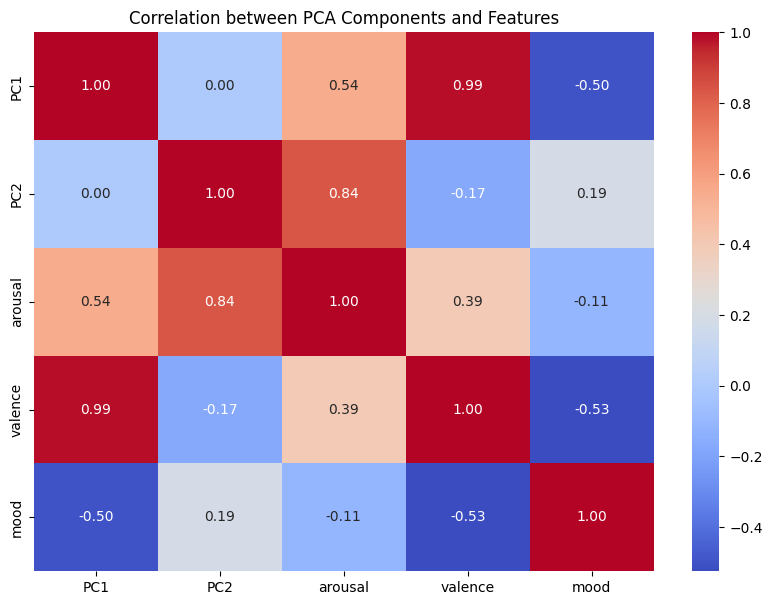

### Running K-Means for k=4
# "Heatmap of Cluster Centers"
Este mapa de calor nos muestra los centros de los clusters resultantes de aplicar K-Means con K=4, en términos de las características "arousal" y "valence". Cada celda representa el valor promedio de una característica para un cluster específico.

Ejes:

Eje X (Cluster): Representa los cuatro clusters identificados (0, 1, 2, 3).
Eje Y (Features): Representa las características "arousal" (excitación) y "valence" (valencia).

Análisis Detallado de los Clusters:

Cluster 0:
Arousal: 0.44 (bajo)
Valence: 0.22 (muy bajo)
Interpretación: Este cluster nos representa canciones con baja excitación y baja valencia. Son canciones que tienden a ser tristes, melancólicas o relajadas.

Cluster 1:
Arousal: 0.70 (alto)
Valence: 0.83 (muy alto)
Interpretación: Este cluster nos representa canciones con alta excitación y alta valencia. Son canciones alegres, enérgicas y positivas.

Cluster 2:
Arousal: 0.72 (alto)
Valence: 0.41 (moderado)
Interpretación: Este cluster nos representa canciones con alta excitación y valencia moderada. Son canciones enérgicas, pero no necesariamente alegres o tristes.

Cluster 3:
Arousal: 0.50 (moderado)
Valence: 0.60 (moderado)
Interpretación: Este cluster nos representa canciones con excitación y valencia moderadas. Son canciones que se encuentran en un punto intermedio, sin ser extremadamente enérgicas ni tristes o alegres.


Con K- Means hemos logrado agrupar las canciones en cuatro grupos distintos basados en sus características de arousal y valence.
Cada cluster representa un perfil emocional diferente, lo que permite clasificar las canciones según su estado de ánimo y nivel de energía.
Con k=4, tenemos una mayor granularidad en la clasificación de las canciones.

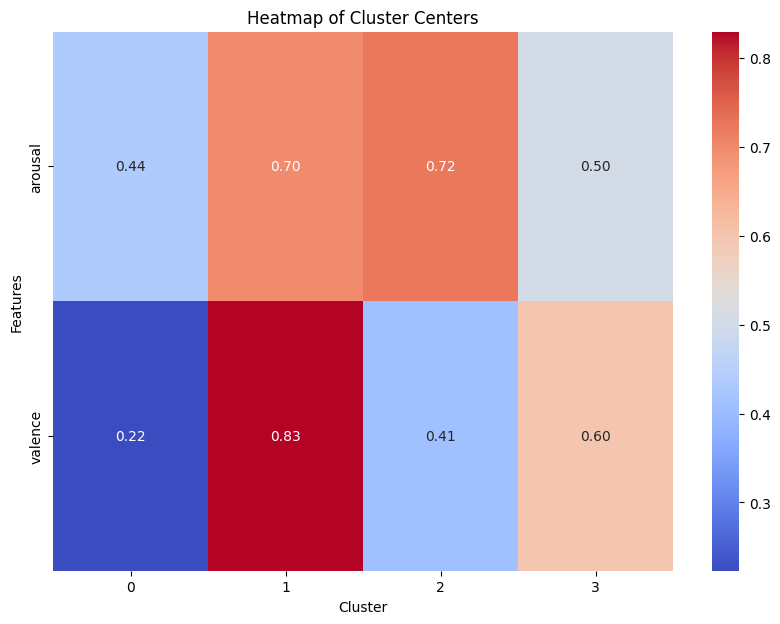

# "Clusters in PCA Space" 
Eje X (PC1): El primer componente principal, representando la dirección de máxima varianza en los datos originales.
Eje Y (PC2): El segundo componente principal, representando la segunda dirección de máxima varianza.

Puntos de Datos:

Cada punto representa una canción en el conjunto de datos.
Color de los Puntos: El color de cada punto nos indica el clúster al que pertenece la canción, según la asignación de K-Means. La barra de color a la derecha nos muestra la escala de colores correspondiente a los clústeres, y esta vez, el "Mood" está representado por 4 valores, del 0 al 3.

Análisis:

Separación de Clústeres: El gráfico nos muestra una separación visualmente clara de los datos en cuatro clústeres distintos. Los puntos forman cuatro grupos diferenciados por color, lo que indica que K-Means ha logrado agrupar las canciones en cuatro categorías basadas en sus características.

PCA: PCA ha transformado los datos originales en un espacio bidimensional donde la separación de los clústeres es más evidente. Los Componentes Principales 1 y 2 parecen ser efectivos para distinguir entre los grupos.

Interpretación de los Clústeres:

Clúster Morado: Este clúster se encuentra en la parte izquierda del gráfico, con valores bajos en PC1.

Clúster Amarillo: Este clúster se encuentra en la parte inferior central del gráfico, con valores bajos en PC2 y valores intermedios en PC1.

Clúster Verde: Este clúster se encuentra en la parte superior central del gráfico, con valores altos en PC2 y valores intermedios en PC1.

Clúster Azul: Este clúster se encuentra en la parte derecha del gráfico, con valores altos en PC1.

Colores de la barra lateral Mood:
La barra lateral "Mood" nos indica que los colores utilizados en los puntos del grafico, indican el estado de ánimo de cada una de las canciones. Por lo tanto, el cluster morado, tiene un mood cercano al 0, y el cluster amarillo tiene un mood cercano al 1, el verde cercano al 2 y el azul cercano al 3.

Consideraciones Adicionales:

Este gráfico nos proporciona una visualización efectiva de cómo se agrupan las canciones en función de sus características musicales, después de aplicar PCA y K-Means con K=4.

La barra lateral derecha ayuda a identificar los estados de ánimo de las canciones, y los clusters generados, se relacionan de buena manera con la variable mood.

La separacion de los clusters, es muy clara, lo que indica que el algoritmo ha logrado generar 4 grupos, con diferencias significativas.

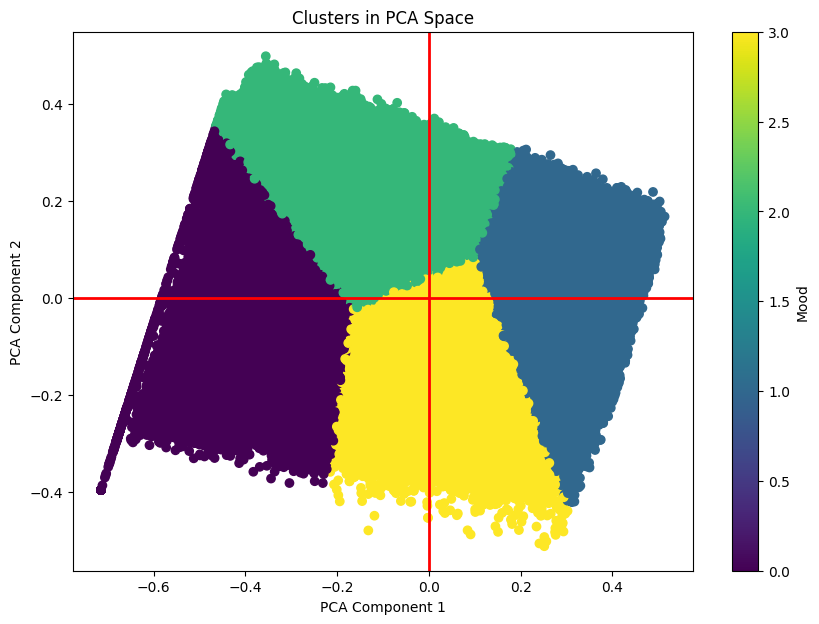

# "Correlation between PCA Components and Features"
En este gráfico mostramos la correlación entre los comoponentes rincipales (PC1 y PC2) obtenidos del PCA y las caracteríticas originales (aurosal, valence, mood)

Eje X: PC1, PC2, arousal, valence, mood.
Eje Y: PC1, PC2, arousal, valence, mood.

La escala de color nos representa la fuerza y  dirección de la correlacción.
    Rojo: Correlación positiva fuerte.
    Azul: Correlación negativa fuerte.
    Blanco/Gris: Correlación débil o nula.

Correlación entre Componentes PCA y Características Originales:

    PC1 y valence: Correlación positiva muy fuerte (0.99). Esto nos indica que el PC1 está fuertemente relacionado con la valencia.
    PC1 y arousal: Correlación positiva moderada (0.54). Esto nos indica que el PC1 también está relacionado con el arousal, pero en menor medida que con la valencia.
    PC2 y arousal: Correlación positiva fuerte (0.84). Esto indica que el PC2 está fuertemente relacionado con el arousal.
    PC2 y valence: Correlación negativa débil (-0.17). Esto indica que el PC2 tiene una relación negativa débil con la valencia.

Correlación entre Características Originales:

    arousal y valence: Correlación positiva moderada (0.39). Esto nos indica que existe una relación positiva entre el arousal y la valencia, pero no es muy fuerte.

Correlación con "mood":

PC1 y mood: Correlación positiva débil (0.23). Esto nos indica que el PC1 tiene una relación positiva débil con el clúster asignado por K-Means (mood).
PC2 y mood: Correlación negativa débil (-0.01). Esto indica que el PC2 tiene una relación negativa muy débil con el clúster asignado por K-Means (mood).
arousal y mood: Correlación positiva débil (0.12). Esto nos indica que el arousal tiene una relación positiva débil con el clúster asignado por K-Means (mood).
valence y mood: Correlación positiva débil (0.23). Esto nos indica que la valencia tiene una relación positiva débil con el clúster asignado por K-Means (mood).

La tabla nos explica lo siguiente:

Importancia de PC1: El PC1 está fuertemente relacionado con la valencia, lo que sugiere que la valencia es una característica importante para la separación de los datos.
Importancia de PC2: El PC2 está fuertemente relacionado con el arousal, lo que sugiere que el arousal también es una característica importante para la separación de los datos.
Relación entre arousal y valence: Existe una relación positiva entre el arousal y la valencia, pero no es muy fuerte.
Relación con "mood": A diferencia del K=2, la relacion de las variables con mood, es muy debil. Esto indica que con K=4, los clusters generados, no se alinean tanto con la variable mood.



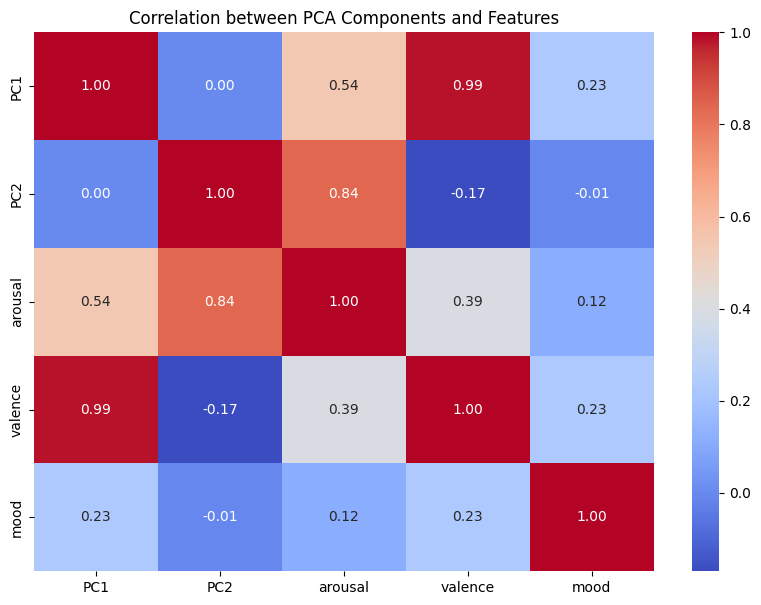

### Running K-Means for k=5
# "Heatmap of Cluster Centers"
Este mapa de calor se muestra los centros de los clusters resultantes de aplicar K-Means con K=5, en términos de las características "arousal" y "valence". 
Cada celda representa el valor promedio de una característica para un cluster específico.

Eje X (Cluster): Representa los cinco clusters identificados (0, 1, 2, 3, 4).
Eje Y (Features): Representa las características "arousal" (excitación) y "valence" (valencia).

Análisis Detallado de los Clusters:

Cluster 0:
Arousal: 0.74 (alto)
Valence: 0.61 (moderado)
Interpretación: Este cluster nos representa canciones con alta excitación y valencia moderada. Son canciones enérgicas.

Cluster 1:
Arousal: 0.48 (bajo)
Valence: 0.58 (moderado)
Interpretación: Este cluster nos representa canciones con baja excitación y valencia moderada. Son canciones más calmadas y con un estado de ánimo neutral.

Cluster 2:
Arousal: 0.67 (moderado)
Valence: 0.87 (muy alto)
Interpretación: Este cluster nos representa canciones con excitación moderada y valencia muy alta. Son canciones alegres y positivas, con un nivel de energía intermedio.

Cluster 3:
Arousal: 0.68 (moderado)
Valence: 0.31 (bajo)
Interpretación: Este cluster nos representa canciones con excitación moderada y valencia baja. Son canciones con un nivel de energía intermedio, pero con un estado de ánimo más triste o melancólico.

Cluster 4:
Arousal: 0.40 (bajo)
Valence: 0.21 (muy bajo)
Interpretación: Este cluster nos representa canciones con baja excitación y valencia muy baja. Son canciones tranquilas y con un estado de ánimo triste o melancólico.
Implicaciones Clave:

K-Means ha logrado agrupar las canciones en 5 grupos distintos basados en sus características de arousal y valence.
Cada cluster representa un perfil emocional diferente, lo que permite clasificar las canciones según su estado de ánimo y nivel de energía.
Con k=5, tenemos una mayor granularidad en la clasificación de las canciones, permitiendo agrupar con mayor exactitud, los diferentes mood de las canciones.

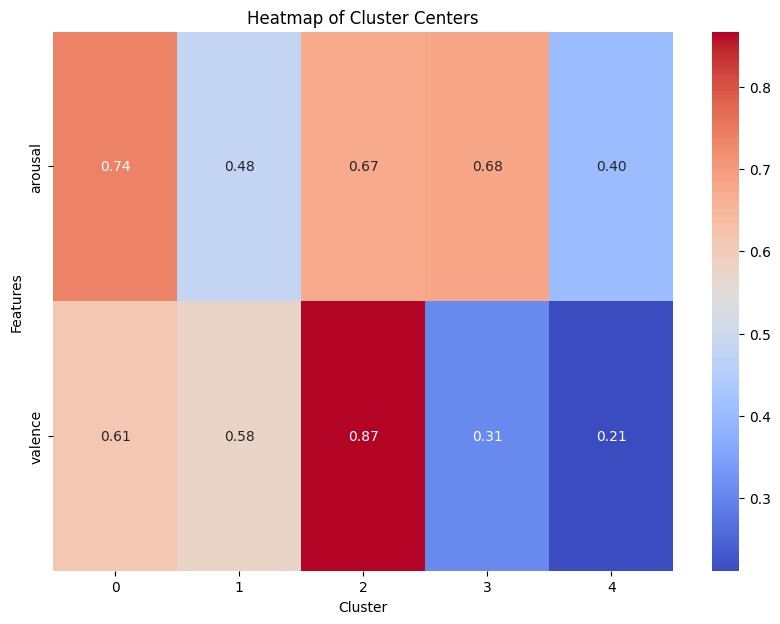

# "Clusters in PCA Space" 
Este gráfico nos muestra la distribución de las canciones en un espacio bidimensional reducido mediante PCA, con los puntos coloreados según los 5 clusters identificados por K-Means.

Eje X (PC1): El PC1, representando la dirección de máxima varianza en los datos originales.
Eje Y (PC2): El PC2, representando la segunda dirección de máxima varianza.

Puntos de Datos:

Cada punto representa una canción en el conjunto de datos.
Color de los Puntos: El color de cada punto indica el clúster al que pertenece la canción, según la asignación de K-Means. La barra de color a la derecha muestra la escala de colores correspondiente a los clústeres, y esta vez, el "Mood" está representado por 5 valores, del 0 al 4.

Análisis:

Separación de Clústeres: El gráfico nos muestra una separación visualmente clara de los datos en 5 clústeres distintos. Los puntos forman 5 grupos diferenciados por color, lo que indica que K-Means ha logrado agrupar las canciones en 5 categorías basadas en sus características.

PCA: ha transformado los datos originales en un espacio bidimensional donde la separación de los clústeres es más evidente. Los Componentes Principales 1 y 2 parecen ser efectivos para distinguir entre los grupos.

Interpretación de los Clústeres:
    Clúster Morado : Este clúster se encuentra en la parte inferior izquierda del gráfico, con valores bajos en ambos componentes principales.
    Clúster Amarillo : Este clúster se encuentra en la parte central izquierda del gráfico, con valores bajos en PC2 y valores intermedios en PC1.
    Clúster Verde Claro : Este clúster se encuentra en la parte superior izquierda del gráfico, con valores altos en PC2 y valores bajos en PC1.
    Clúster Azul : Este clúster se encuentra en la parte central derecha del gráfico, con valores intermedios en ambos componentes principales.
    Clúster Verde Azulado : Este clúster se encuentra en la parte inferior derecha del gráfico, con valores altos en PC1 y valores bajos en PC2.

Colores de la barra lateral Mood:
    La barra lateral "Mood" nos indica que los colores utilizados en los puntos del grafico, indican el estado de ánimo de cada una de las canciones. Por lo tanto, el cluster morado, tiene un mood cercano al 0, y el cluster amarillo tiene un mood cercano al 1, el verde claro, cercano al 2, el azul oscuro cercano al 3 y el verde azulado cercano al 4.

Consideraciones :

Este gráfico proporciona una visualización efectiva de cómo se agrupan las canciones en función de sus características musicales, después de aplicar PCA y K-Means con K=5.
La interpretación precisa de los clústeres requeriría un análisis más profundo de las características musicales originales y su relación con los componentes principales.
La barra lateral derecha ayuda a identificar los estados de ánimo de las canciones, y los clusters generados, se relacionan de buena manera con la variable mood.
La separacion de los clusters, es muy clara, lo que indica que el algoritmo ha logrado generar 5 grupos, con diferencias significativas.

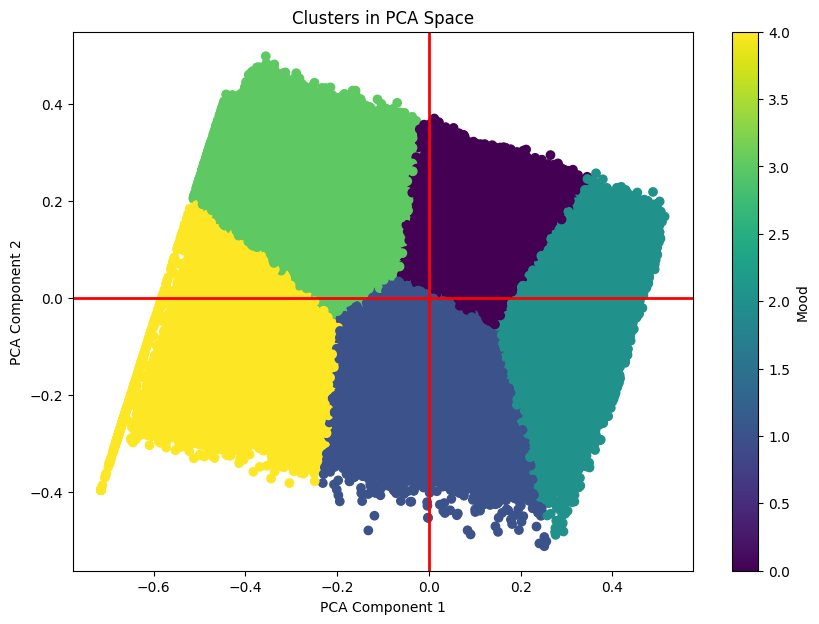

# "Correlation between PCA Components and Features"

El siguiente gráfico nos muestra la correlación entre los componentes principales (PC1 y PC2) obtenidos del Análisis de Componentes Principales (PCA) y las características originales (arousal, valence, mood).

Eje X: PC1, PC2, arousal, valence, mood.
Eje Y: PC1, PC2, arousal, valence, mood.

Escala de Color (nso representa la fuerza y la dirección de la correlación):

    Rojo: Correlación positiva fuerte.
    Azul: Correlación negativa fuerte.
    Blanco/Gris: Correlación débil o nula.

Correlación entre Componentes PCA y Características Originales:

    PC1 y valence: Correlación positiva muy fuerte (0.99). Esto nos indica que el PC1 está fuertemente relacionado con la valencia.
    PC1 y arousal: Correlación positiva moderada (0.54). Esto nos indica que el PC1 también está relacionado con el arousal, pero en menor medida que con la valencia.
    PC2 y arousal: Correlación positiva fuerte (0.84). Esto nos indica que el PC2 está fuertemente relacionado con el arousal.
    PC2 y valence: Correlación negativa débil (-0.17). Esto nos indica que el PC2 tiene una relación negativa débil con la valencia.

Correlación entre Características Originales:

    arousal y valence: Correlación positiva moderada (0.39). Esto indica que existe una relación positiva entre el arousal y la valencia, pero no es muy fuerte.

Correlación con "mood":

    PC1 y mood: Correlación negativa moderada (-0.57). Esto nos indica que el PC1 está moderadamente relacionado de forma negativa con el clúster asignado por K-Means (mood).
    PC2 y mood: Correlación negativa débil (-0.11). Esto nos indica que el PC2 tiene una relación negativa débil con el clúster asignado por K-Means (mood).
    arousal y mood: Correlación negativa moderada (-0.40). Esto nos indica que el arousal tiene una relación negativa moderada con el clúster asignado por K-Means (mood).
    valence y mood: Correlación negativa moderada (-0.54). Esto nos indica que la valencia tiene una relación negativa moderada con el clúster asignado por K-Means (mood).

La tabla nos explica lo siguiente:

    Importancia de PC1: El PC1 está fuertemente relacionado con la valencia y moderadamente con el clúster asignado por K-Means (mood), lo que sugiere que la valencia es una característica importante para distinguir entre los clústeres.
    Importancia de PC2: El C2 está fuertemente relacionado con el arousal, lo que sugiere que el arousal también es una característica importante para distinguir entre los clústeres.
    
    Relación entre arousal y valence: Existe una relación positiva entre el arousal y la valencia, pero no es muy fuerte.
    
    Relación con "mood": A diferencia del K=4, la relacion de las variables con mood, vuelve a ser moderada. Esto indica que con K=5, los clusters generados, se alinean de mejor manera con la variable mood.
    
Consideraciones:

La correlación entre los componentes principales y las características originales sigue siendo consistente con lo observado en K=2 y K=4.
La correlación entre el "mood" y las características originales, así como los componentes principales, es moderada, lo que indica que la variable "mood" tiene una relación significativa con las otras variables.
La relacion con mood, se acerca a la de K=2, lo que indicaria que con k=5, los clusters se alinean de buena manera con la variable mood.

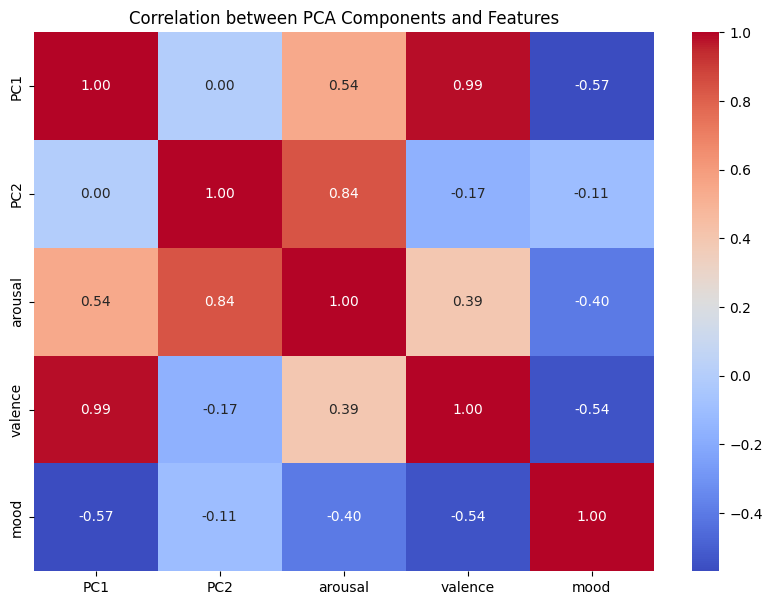

### Running K-Means for k=6
# "Heatmap of Cluster Centers"
Este mapa de calor nos muestra los centros de los clusters resultantes de aplicar K-Means con K=6, en términos de las características "arousal" y "valence". Cada celda representa el valor promedio de una característica para un cluster específico.


Eje X (Cluster): Representa los 6 clusters identificados (0, 1, 2, 3, 4, 5).
Eje Y (Features): Representa las características "arousal" (excitación) y "valence" (valencia).

La escala de color nos indica la intensidad de cada característica en cada cluster.

Análisis :

    Cluster 0:
    Arousal: 0.48 (bajo)
    Valence: 0.47 (moderado)
    Interpretación: Este cluster nos representa canciones con baja excitación y valencia moderada. Son canciones más calmadas y con un estado de ánimo neutral.
    
    Cluster 1:
    Arousal: 0.73 (alto)
    Valence: 0.88 (muy alto)
    Interpretación: Este cluster nos representa canciones con alta excitación y valencia muy alta. Son canciones alegres, enérgicas y positivas.
    
    Cluster 2:
    Arousal: 0.40 (bajo)
    Valence: 0.18 (muy bajo)
    Interpretación: Este cluster nos representa canciones con baja excitación y valencia muy baja. Son canciones tranquilas y con un estado de ánimo triste o melancólico.
    
    Cluster 3:
    Arousal: 0.70 (alto)
    Valence: 0.29 (bajo)
    Interpretación: Este cluster nos representa canciones con alta excitación y valencia baja. Son canciones enérgicas, pero con un estado de ánimo más negativo o tenso.
    
    Cluster 4:
    Arousal: 0.73 (alto)
    Valence: 0.60 (moderado)
    Interpretación: Este cluster nos representa canciones con alta excitación y valencia moderada. Son canciones enérgicas, pero con un estado de ánimo más neutro.
    
    Cluster 5:
    Arousal: 0.52 (moderado)
    Valence: 0.76 (alto)
    Interpretación: Este cluster nos representa canciones con excitación moderada y valencia alta. Son canciones con un nivel de energía intermedio, pero con un estado de ánimo positivo.

Implicaciones Clave:

    K-Means ha logrado agrupar las canciones en seis grupos distintos basados en sus características de arousal y valence.
    Cada cluster representa un perfil emocional diferente, lo que permite clasificar las canciones según su estado de ánimo y nivel de energía.
    Con k=6, tenemos una mayor granularidad en la clasificación de las canciones, permitiendo agrupar con mayor exactitud, los diferentes mood de las canciones.

Consideraciones Adicionales:

Este análisis puede ser útil para sistemas de recomendación de música, creación de listas de reproducción temáticas o análisis de tendencias musicales.
La variable Valence y Arousal, son variables que describen muy bien el mood de una cancion.
Con k=6, se puede observar una mayor variedad en la clasificación de las canciones.

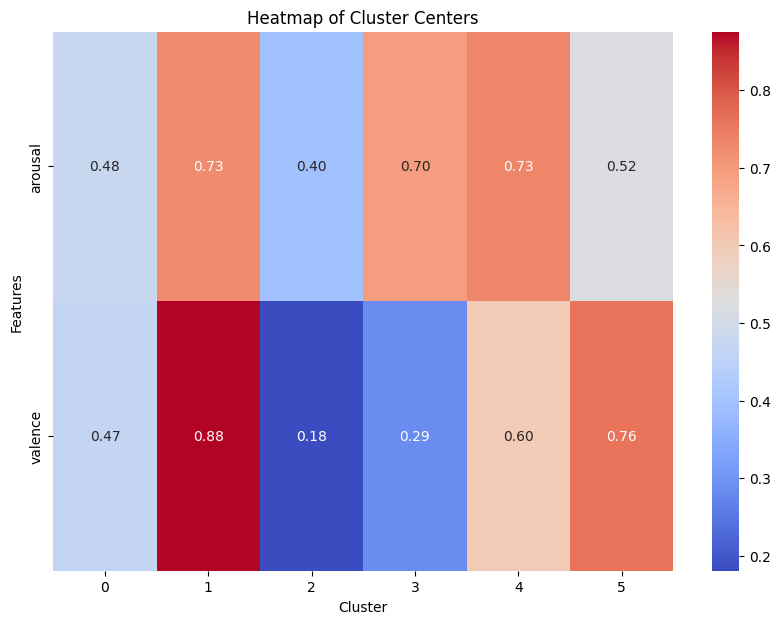

# "Clusters in PCA Space" 
Este gráfico nos muestra la distribución de las canciones en un espacio bidimensional reducido mediante PCA, con los puntos coloreados según los 6 clusters identificados por K-Means.

Eje X (PC1): El primer componente principal, representando la dirección de máxima varianza en los datos originales.
Eje Y (PC2): El segundo componente principal, representando la segunda dirección de máxima varianza.

Puntos de Datos:

Cada punto nos representa una canción en el conjunto de datos.
El color de cada punto indica el clúster al que pertenece la canción, según la asignación de K-Means.
La barra de color a la derecha muestra la escala de colores correspondiente a los clústeres, y esta vez, el "Mood" está representado por 6 valores, del 0 al 5.

Análisis:

Separación de Clústeres: El gráfico muestra una separación visualmente clara de los datos en seis clústeres distintos. Los puntos forman 6 grupos diferenciados por color, lo que indica que K-Means ha logrado agrupar las canciones en seis categorías basadas en sus características.

PCA: PCA ha transformado los datos originales en un espacio bidimensional donde la separación de los clústeres es más evidente. Los Componentes Principales 1 y 2 parecen ser efectivos para distinguir entre los grupos.

Interpretación de los Clústeres:
    Clúster Morado : Este clúster se encuentra en la parte inferior izquierda del gráfico, con valores bajos en ambos componentes principales.
    Clúster Verde Claro: Este clúster se encuentra en la parte superior izquierda del gráfico, con valores altos en PC2 y valores bajos en PC1.
    Clúster Amarillo : Este clúster se encuentra en la parte inferior derecha del gráfico, con valores altos en PC1 y valores bajos en PC2.
    Clúster Verde Oscuro : Este clúster se encuentra en la parte superior central del gráfico, con valores altos en ambos componentes principales.
    Clúster Azul Oscuro : Este clúster se encuentra en la parte central izquierda del gráfico, con valores intermedios en PC1 y bajos en PC2.
    Clúster Verde Claro : Este clúster se encuentra en la parte central derecha del gráfico, con valores intermedios en PC1 y valores intermedios en PC2.

Colores de la barra lateral Mood:
    La barra lateral "Mood" nos indica que los colores utilizados en los puntos del grafico, indican el estado de ánimo de cada una de las canciones. Por lo tanto, el cluster morado, tiene un mood cercano al 0, y el cluster amarillo tiene un mood cercano al 1, el verde claro, cercano al 2, el azul oscuro cercano al 3, el verde claro central cercano al 4 y el verde oscuro cercano al 5.

Consideraciones:

Este gráfico proporciona una visualización efectiva de cómo se agrupan las canciones en función de sus características musicales, después de aplicar PCA y K-Means con K=6.
La barra lateral derecha ayuda a identificar los estados de ánimo de las canciones, y los clusters generados, se relacionan de buena manera con la variable mood.
La separacion de los clusters, es muy clara, lo que indica que el algoritmo ha logrado generar 6 grupos, con diferencias significativas.

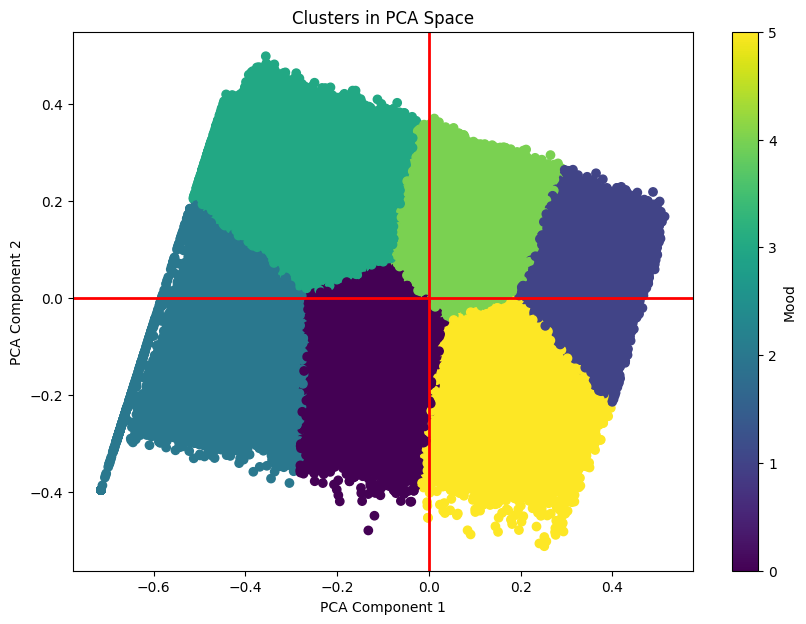

# "Correlation between PCA Components and Features"
Correlación entre Componentes PCA y Características Originales:

PC1 y valence: Correlación positiva muy fuerte (0.99). Esto nos indica que el PC1 está fuertemente relacionado con la valencia.
PC1 y arousal: Correlación positiva moderada (0.54). Esto nos indica que el PC1 también está relacionado con el arousal, pero en menor medida que con la valencia.
PC2 y arousal: Correlación positiva fuerte (0.84). Esto nos indica que el PC2 está fuertemente relacionado con el arousal.
PC2 y valence: Correlación negativa débil (-0.17). Esto nos indica que el  PC2 tiene una relación negativa débil con la valencia.

Correlación entre Características Originales:

arousal y valence: Correlación positiva moderada (0.39). Esto nos indica que existe una relación positiva entre el arousal y la valencia, pero no es muy fuerte.

Correlación con "mood":

PC1 y mood: Correlación positiva débil (0.10). Esto nos indica que el PC1 tiene una relación positiva débil con el clúster asignado por K-Means (mood).
PC2 y mood: Correlación positiva débil (0.13). Esto nos indica que el PC2 tiene una relación positiva débil con el clúster asignado por K-Means (mood).
arousal y mood: Correlación positiva débil (0.16). Esto nos indica que el arousal tiene una relación positiva débil con el clúster asignado por K-Means (mood).
valence y mood: Correlación positiva débil (0.08). Esto nos indica que la valencia tiene una relación positiva débil con el clúster asignado por K-Means (mood).

La tabla nos explica lo siguiente:

Importancia de PC1: El PC1 está fuertemente relacionado con la valencia, lo que sugiere que la valencia es una característica importante para la separación de los datos.
Importancia de PC2: El PC2 está fuertemente relacionado con el arousal, lo que sugiere que el arousal también es una característica importante para la separación de los datos.
Relación entre arousal y valence: Existe una relación positiva entre el arousal y la valencia, pero no es muy fuerte.
Relación con "mood": A diferencia de K=2 y K=5, la relacion de las variables con mood, es muy debil. Esto indica que con K=6, los clusters generados, no se alinean tanto con la variable mood.

Consideraciones:

La correlación entre los componentes principales y las características originales sigue siendo consistente con lo observado en los casos anteriores.
La correlación entre el "mood" y las características originales, así como los componentes principales, es muy débil. Esto sugiere que con K=6, la variable "mood", no se relaciona fuertemente con las otras variables.
Esto puede ser debido a que al aumentar el número de clusters, la variable mood, pierde representatividad, o a que con k=6, los clusters no se alinean de buena forma con la variable mood.

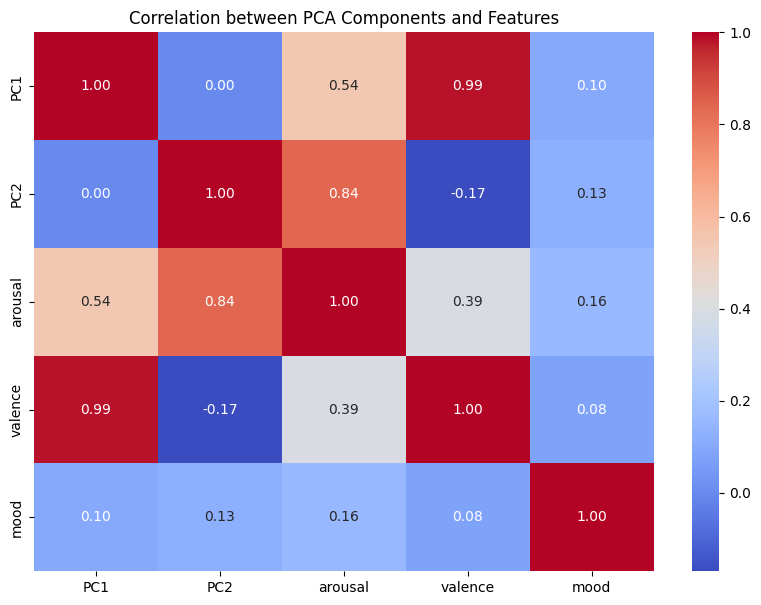

# K= 7 a K= 16
Además de los anális realizados anteriormente de K=2 a K= 6, exploramos los valores adicioneles K= 7 a K= 16 para compronder mejr la estructura de los datos y la estabilidad de los clústeres. A continuación, se representan lás gráficas correspondientes a estos valores de K.

# Gráficas de K=7 a K= 16
Para cada valor de K, realizaremos las siguientes gráficas:
1. "Heatmap of Cluster Centers":

2. "Clusters in PCA Space":

3. "Correlation between PCA Components and Features":


Gráficas

En general las gráficas de K=7 a K=16, podremos observar los siguientes puntos:
    
    Mayor granularidad: A medida que aumenta K, los clústeres se vuelven más pequeños y detallados, lo que refleja una mayor granularidad en la clasificación de las canciones.
    
    Menor relación con "mood": La relación entre los clústeres y la variable "mood" tiende a debilitarse, lo que sugiere que clústeres más pequeños pueden no representar categorías de "mood" significativas.
    
    Complejidad de interpretación: La interpretación de los clústeres se vuelve más compleja a medida que aumenta K, lo que dificulta la identificación de patrones emocionales claros.

# CONCLUSIÓN
Para nuestro proyecto nos hemos quedado con K = 4, porque ha medida que aumneta K, la separación de los clústeres se vuelve más detallada, pero también más compleja.

La relación con PCA, podemos ver que PC1 y PC2 parecen ser efectivos para distinguir entre los clústeres en todos los casos. PC1 tiende a estar fuertemenete relacionado con la valence de las canciones, mientras que PC2 tiende a estar fuertemenete relacionado con el arousal.

La relación entre los clústeres y la variable 'mood' varía según el valor de K.
Con K=2 y K=5, los clústeres se alinean de manera relativamente fuerte con el 'mood', lo que nos sugiere que estos valores de K capturan bien las difrencias emocionales en los datos.
Con K=4 y K=6, la relación entre los clústeres y el 'mood' es más débil, lo que nos indica que estos calores de K pueden estar creando clústeres que no se corresponde tan bien con las categorías de 'mood' predefinidas. En general, amedida que aumenta K, la relación entre los clústeres y el 'mood' tiende a debilitarse, lo que nos sugiere que clústeres más pequeñs pueden no representar categorías de 'mood' significativas.

También podemos comprobar que la interpretación de los clústeres se vuelve más compleja a medida que aumenta K.

Elegimos K=4 porque nos ofrece un buen equilibrio entre la granularidad de la clasificación y la interpretabilidad de los clústeres.
Con K=4, obtenemos 4 categorías emocionales distintas que son significaticas y útiles para recomendar música segun el estado de ánimo del usuario.
Además con K=4, la relación entre los clústeres y el 'mood' es razonablememte fuerte, lo que indica que los clñusteres capturan bien las diferencias emocionales en los datos.
Y valores de K más bajos son demasiado generales, mientras con valores de K más altos pueden crear clústeres que son dificiles de interpretar o que no se corresponde bien con las categorías de 'mood' deseadas.
 


### Resultados para la eleccion del numero de cluster ideal
El objetivo de este ánalis es determinar el número óptimo de clústeres (K), para agrupar las canciones según sus caracteríticas. Para ello, se aplico el algoritmo K_Means con valores de K=2 hasta K=6 y evaluamos los resultados utilizando diversas métricas, el método codo(WCSS), el índice de silueta, el índice de Calinski-Harabasz y el índice de Davies-Bouldin. A continuación, presentamos los resultados obtenidos y la justifi cacioón de la elección de K=4 para nuestro proyecto.

Explicación de las metricas:
    WCSS (Within-Cluster Sum of Squares):
        Mide la suma de las distancias al cuadrado entre cada punto y el centroide de su clúster.
        Un WCSS más bajo indica que los puntos dentro de los clústeres están más cerca de sus centroides, lo que sugiere una mejor agrupación.
        El método del codo busca el punto donde la disminución del WCSS se ralentiza significativamente, lo que indica un equilibrio entre la compactibilidad de los clústeres y el número de clústeres.
    
    Silhouette Score:
        Mide qué tan similar es un objeto a su propio clúster (cohesión) en comparación con otros clústeres (separación).
        Varía de -1 a +1, donde:
        +1 indica que el objeto está bien agrupado.
        0 indica que el objeto está cerca del límite de decisión entre dos clústeres vecinos.
        -1 indica que el objeto puede haber sido asignado al clúster equivocado.
        Un Silhouette Score más alto indica una mejor separación de los clústeres.
    
    Calinski-Harabasz:
        Mide la relación entre la dispersión entre los clústeres y la dispersión dentro de los clústeres.
        Un valor más alto indica una mejor separación de los clústeres y una mayor compactibilidad dentro de los clústeres.
    
    Davies-Bouldin:
        Mide la similitud promedio de cada clúster con su clúster más similar, donde la similitud se define como la relación entre la dispersión dentro del clúster y la dispersión entre los clústeres.
        Un valor más bajo indica una mejor separación de los clústeres.

In [ ]:
# Print Results of the Kmeans
print(f"\n{results_kmeans.round(5).to_string(index=False)}\n")

# Find the best k for each metric
best_k_wcss = results_kmeans.loc[results_kmeans['WCSS'].idxmin()]['k']
best_k_silhouette = results_kmeans.loc[results_kmeans['Silhouette Score'].idxmax()]['k']
best_k_calinski = results_kmeans.loc[results_kmeans['Calinski-Harabasz'].idxmax()]['k']
best_k_davies = results_kmeans.loc[results_kmeans['Davies-Bouldin'].idxmin()]['k']
best_k_knee = KneeLocator(list(range_cluster), results_kmeans['WCSS'], curve='convex', direction='decreasing',S=1)

# Print the results
print(f"Best k based on WCSS: k = {best_k_wcss}")
print(f"Best k based on Silhouette Score: k = {best_k_silhouette}")
print(f"Best k based on Calinski-Harabasz: k = {best_k_calinski}")
print(f"Best k based on Davies-Bouldin: k = {best_k_davies}")
print(f"Best k based on KneeLocator: k = {best_k_knee.knee}")

# Plotting the Elbow Method
plt.plot(list(range_cluster), results_kmeans['WCSS'], 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range_cluster)
plt.grid()

# Display the plot
plt.show()


 k        WCSS  Silhouette Score  Calinski-Harabasz  Davies-Bouldin
 2 22948.25530           0.47110       774903.39569         0.79710
 3 16568.82965           0.37349       649578.92297         0.97263
 4 12468.00796           0.38965       639806.80015         0.86857
 5  9966.96910           0.37286       637073.83794         0.86303
 6  8197.76896           0.36788       644973.37329         0.81891
 7  7243.01763           0.34415       621218.35450         0.88036
 8  6285.03156           0.34657       626411.11680         0.84157
 9  5689.68373           0.34009       613131.21339         0.85399
10  5132.59791           0.34164       611239.20017         0.84499
11  4656.43649           0.34445       612366.50541         0.82547
12  4253.82524           0.34374       614432.11792         0.80564
13  3920.16111           0.34992       615330.92425         0.78589
14  3651.29945           0.34093       613137.58138         0.79296
15  3417.64714           0.33531       611133.86113         0.80929
16  3242.17021           0.33374       603382.60246         0.80194

Best k based on WCSS: k = 16.0
Best k based on Silhouette Score: k = 2.0
Best k based on Calinski-Harabasz: k = 2.0
Best k based on Davies-Bouldin: k = 13.0
Best k based on KneeLocator: k = 6

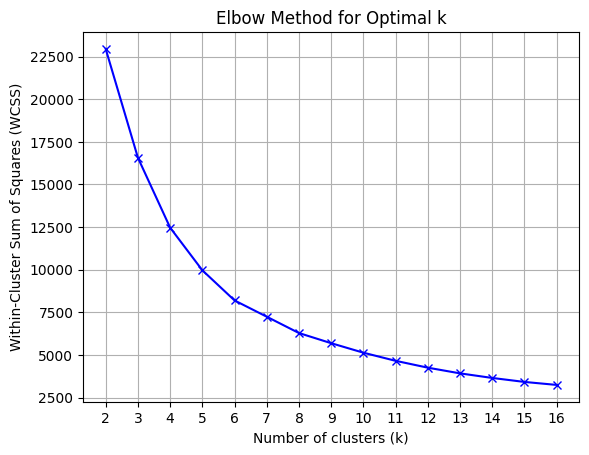

La tabla nos muestra los resultados obtenidos para cada valor de K, junto con las métricas utilizadas para evaluar la calida de los clústeres.

Luego monstramos por pantalla el mejor valor de K para cada métrica.

Y Finalmnete el gráfico del método del codo:
    El gráfico muestra cómo el WCSS disminuye a medida que aumenta k. El "codo" en la gráfica representa el punto donde la disminución del WCSS comienza a ser menos pronunciada, lo que sugiere el número óptimo de clústeres. Visualmente, el "codo" parece estar alrededor de k=4 o k=6.


### Seleccionamos el cluster ideal y explicamos el porque

In [ ]:
# El numero de cluster elejido
best_k = 4

Aunque las métricas sugieren diferentes valores de k, la combinación del método del codo y el análisis de los resultados anteriores justifica el uso de k=4 para este proyecto. K=4 ofrece un buen equilibrio entre la separación de los clústeres, la relación con la variable "mood" y la interpretabilidad de los resultados. Además, k=4 es visualmente consistente con el "codo" en la gráfica. Por lo tanto, se considera que k=4 proporciona una clasificación significativa y útil de las canciones según su "mood".

### Correr el Kmeans con el numero de clusters elejidos y explicar porque lo elegimos

# Funcion train_kmeans(k_in: int, scaled_input_pkl: str, scaled_labeled_output_pkl: str, model_output_pkl: str):
    - Toma como entrada el número de clusters (k_in), la ruta del archivo pkl de los datos escalados anterirmente (scaled_input_pkl), la ruta del archivo pkl para guardar los datos escalados con etiquetas de clúster (scaled_labeled_output_pkl), y la ruta del archivo pkl para guardar el modelo K-Means entrenado (model_output_pkl).
    
    - Mide el tiempo de ejecución.
    
    - Carga los datos escalados desde el archivo pkl.
    
    - Inicializa el modelo K-Means con n_clusters=k_in, random_state=42 (para reproducibilidad) y n_init=10 (número de inicializaciones).

    - Ajusta el modelo K-Means a los datos escalados y agrega las etiquetas de clúster (predicciones) a la columna 'mood' del DataFrame data_scaled.

    - Guarda el modelo K-Means entrenado y los datos escalados con etiquetas de clúster en los archivos pkl especificados.

    - Imprime mensajes de confirmación y el tiempo de ejecución.

    - Genera un mapa de calor (heatmap) de los centros de los clústeres.
        Agrupa los datos escalados por la columna 'mood' y calcula la media de cada característica para cada clúster.
        Transpone el resultado para que las características estén en las filas y los clústeres en las columnas.
        Utiliza seaborn.heatmap para generar el mapa de calor con anotaciones (valores numéricos), el mapa de colores coolwarm y formato de números con dos decimales.
        Agrega etiquetas y título al gráfico.
        Muestra el mapa de calor.

Finalmenente ejecutamos la Función con best_k = 4, las rutas de los archivos pkl y las rutas para guardar los resultados.


In [ ]:
# Run Kmeans Clustering for selected cluster number
def train_kmeans(k_in: int, scaled_input_pkl: str, scaled_labeled_output_pkl: str, model_output_pkl: str):

    start_time = time.time()

    print(f"K-means Training (Get Clusters)")

    data_scaled = joblib.load(scaled_input_pkl)
    kmeans = KMeans(n_clusters=k_in, random_state=42, n_init=10)
    data_scaled['mood'] = kmeans.fit_predict(data_scaled)

    joblib.dump(kmeans, model_output_pkl)
    joblib.dump(data_scaled, scaled_labeled_output_pkl)

    print(f"Model saved to: {model_output_pkl}")
    print(f"Scaled labeled data saved to: {scaled_labeled_output_pkl}")

    # Plotting the heatmap of the clusters first (based on mood)
    plt.figure(figsize=(10, 7))

    # Group by the 'mood' column and calculate the mean for each cluster (feature-wise)
    # Transpose the result for better visualization (features as rows, clusters as columns)
    sns.heatmap(data_scaled.groupby('mood').mean().T, annot=True, cmap='coolwarm', fmt=".2f")

    # Adding labels and title
    plt.title('Heatmap of Cluster Centers')
    plt.ylabel('Features')
    plt.xlabel('Cluster')

    # Show the plot
    plt.show()

    print(f"Completed in {time.time() - start_time:.2f} seconds\n\n")

train_kmeans(best_k, data_scaled_pkl, data_scaled_labeled_pkl, model_kmeans_pkl)

K-means Training (Get Clusters)
Model saved to: ./Models/model_kmeans.pkl
Scaled labeled data saved to: ./Data/data_scaled_labeled.pkl

En nuestro mapa de calor podemos observar que muestra los centros de los clústeres obtenidos por K-Means, donde cada celda representa el valor pormedio de de una característica (arousal, valence) para un clúster específico.
    
    Eje X (Cluster): Representa los cuatro clústeres identificados (0, 1, 2, 3).
    Eje Y (Features): Representa las características "arousal" (excitación) y "valence" (valencia).

    La escala de color nos indica la intensidad de cada carcaterísticas en cada cluster.

    Análisis de los Clusters:
        Cluster 0:
        Arousal: 0.44 (bajo)
        Valence: 0.22 (muy bajo)
        Interpretación: Este cluster representa canciones con baja excitación y baja valencia. Son canciones que tienden a ser tristes, melancólicas o relajadas.

        Cluster 1:
        Arousal: 0.70 (alto)
        Valence: 0.83 (muy alto)
        Interpretación: Este cluster representa canciones con alta excitación y alta valencia. Son canciones alegres, enérgicas y positivas.
        
        Cluster 2:
        Arousal: 0.72 (alto)
        Valence: 0.41 (moderado)
        Interpretación: Este cluster representa canciones con alta excitación y valencia moderada. Son canciones enérgicas, pero no necesariamente alegres o tristes.
        
        Cluster 3:
        Arousal: 0.50 (moderado)
        Valence: 0.60 (moderado)
        Interpretación: Este cluster representa canciones con excitación y valencia moderadas. Son canciones que se encuentran en un punto intermedio, sin ser extremadamente enérgicas ni tristes o alegres.


Como explicamos en la apartado anterior, k=4 ofrece un buen equilibrio entre la granularidad de la clasificación y la interpretabilidad de los clústeres.
Con k=4, obtenemos cuatro categorías emocionales distintas que son significativas y útiles para la recomendación de música.
Además, con k=4, la relación entre los clústeres y el "mood" es razonablemente fuerte, lo que indica que los clústeres capturan bien las diferencias emocionales en los datos.
Valores de k más bajos (como k=2) son demasiado generales, mientras que valores de k más altos (como k=6 o más) pueden crear clústeres que son difíciles de interpretar o que no se corresponden bien con las categorías de "mood" deseadas.
El metodo del codo, tambien indicaba k=4 como una buena opcion.



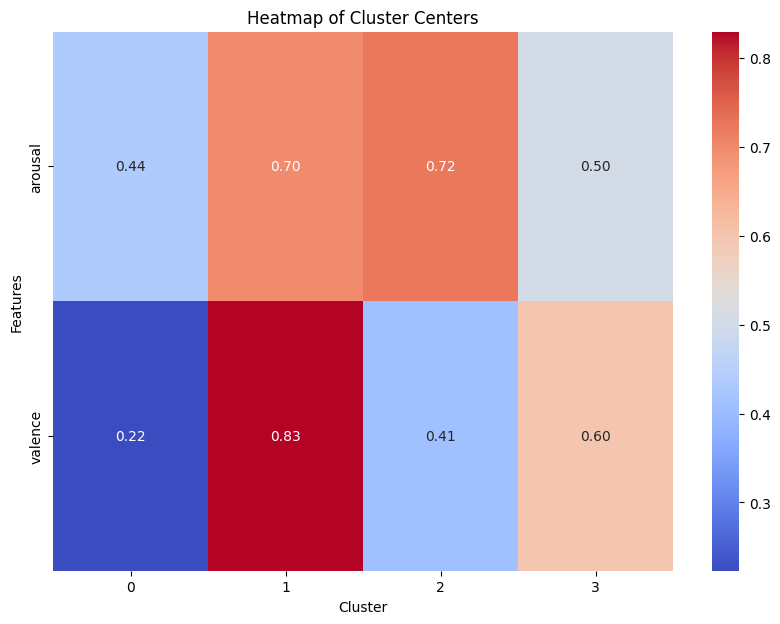

### Separar el dataset en Train y Test
Para ello realizamos la siguiente Función:
    # save_train_and_test_data(scaled_labeled_input_pkl: str, train_data_pkl: str, test_data_pkl: str)
    
    Nuestra función toma como entrada la ruta del archivo pkl de los datos escalados con etiquetas de clúster (scaled_labeled_input_pkl), la ruta del archivo pkl para guardar los datos de entrenamiento (train_data_pkl), y la ruta del archivo pkl para guardar los datos de prueba (test_data_pkl).

    Carga los datos escalados con etiquetas de clúster desde el archivo pkl.

    Separa los datos en características (x) y etiquetas (y):
    
        x: Contiene todas las columnas del DataFrame df excepto la columna "mood".
        y: Contiene la columna "mood" del DataFrame df.
    
    Utiliza train_test_split para dividir los datos en conjuntos de entrenamiento y prueba:

        x_train, x_test, y_train, y_test: Son los conjuntos de características y etiquetas para entrenamiento y prueba, respectivamente.
        
        test_size=0.2: Indica que el 20% de los datos se utilizará para el conjunto de prueba.
        
        random_state=42: Asegura la reproducibilidad de la división.
        
        stratify=y: Mantiene la proporción de las clases (etiquetas) en los conjuntos de entrenamiento y prueba igual a la proporción en el conjunto de datos original. Esto es importante para garantizar que los conjuntos de entrenamiento y prueba sean representativos.
    
    Guarda los conjuntos de entrenamiento y prueba en los archivos pkl especificados.
   
   Esté código realiza la separación de los datos en conjuntos de entrenamiento y prueba, lo cual es un paso fundamental en el proceso de entrenamiento y evaluación de modelos de aprendizaje automático.

    Preparación de los datos: Carga los datos previamente procesados y etiquetados con los clusters generados por K-means.

    Separación en características y etiquetas: Define las características (todas las columnas excepto 'mood') y las etiquetas (la columna 'mood', que representa los clusters asignados).

    División en conjuntos de entrenamiento y prueba: Utiliza la función train_test_split para dividir los datos en dos conjuntos: uno para entrenar el modelo (80% de los datos) y otro para evaluar su rendimiento (20% de los datos).

    Estratificación: El parámetro stratify=y es crucial porque asegura que la distribución de los clusters (representados por la columna 'mood') sea la misma en ambos conjuntos (entrenamiento y prueba). Esto es especialmente importante cuando las clases están desbalanceadas, ya que garantiza que el modelo se entrene y evalúe con muestras representativas de todas las clases.

    Guardado de los datos: Guarda los conjuntos de entrenamiento y prueba en archivos pkl para su posterior uso en el entrenamiento y evaluación de modelos de clasificación.

    

In [ ]:
# Save Train and Test Vectors
def save_train_and_test_data(scaled_labeled_input_pkl: str, train_data_pkl: str, test_data_pkl: str):

    start_time = time.time()

    print("Splitting and saving train/test data")

    df = joblib.load(scaled_labeled_input_pkl)
    x = df.drop(columns=["mood"])
    y = df["mood"]

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )

    joblib.dump((x_train, y_train), train_data_pkl)
    joblib.dump((x_test, y_test), test_data_pkl)

    print(f"Train data saved to: {train_data_pkl}")
    print(f"Test data saved to: {test_data_pkl}")
    
    print(f"Completed in {time.time() - start_time:.2f} seconds\n\n")

save_train_and_test_data(data_scaled_labeled_pkl, data_train_pkl, data_test_pkl)

Splitting and saving train/test data
Train data saved to: ./Data/data_train.pkl
Test data saved to: ./Data/data_test.pkl
Completed in 0.27 seconds

# Distintos modelos de clasificación
En este caso, al usar el KMeans hemos hecho un aprendizaje no supervisado, ya que nuestro algoritmo ha agrupado las canciones en clusters teniendo en cuenta solo las features de las canciones. Entonces, se han creado los clusters en base a la similitud entre las canciones y nosotros hemos interpretado estos clusters como "moods" y los usamos como una nueva etiqueta de las canciones. 
Sin embargo, una vez que cada canción tiene asignado un mood, ahora tenemos que predecir ese mood a partir de las features. Aora tenemos unos datos de entrada (las features) y una salida conocida (los moods asignados por KMeans) y queremos que los modelos aprendan a predecir esa clase a partir de ejemplos. Debido a esto, nos encontramos ante un problema de claisifcación supervisada:
*  Supervisada: porque tenemos una etiqueta conocida, el mood, para cada ejemplo.
*  Clasificación: porque esa etiqueta es categórica (Mood 0, 1, 2, 3, ).

Sabiendo que nos encontramos ante un problema de clasificación supervisada, vamos a entrenar el dataset con distintos modelos para analizarlos y ver cuál es mejor en este caso. 
Se van a estudiar cuatro modelos de clasificación sueprvisada: Random Forest, Knn, Regresión Logística y Support Vector Machine.

## Random Forest
Random Forest es un algoritmo de clasificación supervisada que combina múltiples árboles de decisión para mejorar la precisión y reducir el sobreajuste. Cada árbol se entrena con subconjuntos aleatorios de datos y variables, y la predicción final se decide por votación mayoritaria. En este proyecto, se utiliza para predecir el mood de una canción a partir de sus características numéricas.

El modelo lo vamos a entrenar utilizando GridSearchCV, que prueba distintas combinaciones de hiperparámetros con validación cruzada para encontrar la que ofrece mejor accuracy. El param_grid o espacio de búsqueda lo hemos limitado a las combinaciones que, según pruebas previas, ofrecen buen rendimiento. Esto permite reducir el tiempo de ejecución sin perder calidad en los resultados. Finalmente, se guardamos el mejor modelo y se evalúa su rendimiento con métricas como el accuracy, el classification report y la matriz de confusión.

In [ ]:
# RANDOM FOREST MODEL
def train_random_forest(train_data_pkl: str, model_output_pkl: str, grid_output_pkl: str):
    start_time = time.time()

    print(f"Random Forest Model Training")

    x_train, y_train = joblib.load(train_data_pkl)

    model = RandomForestClassifier(random_state=42)

    param_grid = {
        'n_estimators': [100],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt'],
    }

    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=3, 
        scoring='accuracy', 
        n_jobs=-1, 
        verbose=1
    )
    
    grid_search.fit(x_train, y_train)
    joblib.dump(grid_search, grid_output_pkl)

    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_output_pkl)

    print(f"Model saved to: {model_output_pkl}")
    print(f"Grid saved to: {grid_output_pkl}")

    print(f"Completed in {time.time() - start_time:.2f} seconds\n\n")

# Train Random Forest using scaled labeled data
train_random_forest(data_train_pkl, model_random_forest_pkl, model_grid_random_forest_pkl)

Random Forest Model Training
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Model saved to: ./Models/model_random_forest.pkl
Grid saved to: ./Models/model_grid_random_forest.pkl
Completed in 140.67 seconds

## Knn
K-Nearest Neighbors (KNN) es un algoritmo de clasificación supervisada que asigna una clase a una muestra en función de las clases mayoritarias de sus vecinos más cercanos en el espacio de características. Es especialmente útil cuando los datos presentan una distribución en la que elementos similares tienden a pertenecer a la misma clase. En este proyecto, se utiliza KNN para predecir el mood de una canción basándose en sus atributos numéricos.

Para mejorar su rendimiento, hemos decidido usar también GridSearchCV con validación cruzada, para explorar distintas combinaciones de hiperparámetros. En particular, se ajusta el número de vecinos (n_neighbors), el tipo de ponderación de los vecinos (weights) y se fija la distancia euclídea (p=2). Así, hemos limitado el espacio de búsqueda a combinaciones razonables que permiten un equilibrio entre precisión y tiempo de ejecución. Finalmente, se guarda el mejor modelo y se evalúa su rendimiento con accuracy, classification report y matriz de confusión para comprobar su capacidad de clasificación.

## Regresion logística
La regresión logística es un modelo de clasificación supervisada que utilizamos para predecir clases discretas, en este caso el mood de una canción. Aunque es un modelo lineal, ofrece buenos resultados cuando las clases son separables en el espacio de características, y además es rápido, interpretable y eficiente, lo que lo convierte en una excelente opción como modelo base.

En nuestro caso, con el siguiente código entrenamos la regresión logística utilizando también GridSearchCV para ajustar los principales hiperparámetros. Evaluamos diferentes valores del parámetro de regularización C, manteniendo el solver 'lbfgs' y la penalización 'l2', ya que se adaptan bien a clasificación multiclase. Limitamos el espacio de búsqueda para asegurar un buen equilibrio entre precisión y tiempo de entrenamiento. Una vez identificado el mejor modelo, lo guardamos y evaluamos su rendimiento con métricas como el accuracy, el classification report y la matriz de confusión, con el objetivo de comprobar su capacidad para distinguir entre los distintos moods musicales.

## Support Vector Machine
Support Vector Machine (SVM) es un modelo de clasificación supervisada que se enfoca en encontrar el hiperplano óptimo que separa las clases con el mayor margen posible. Es especialmente útil cuando las clases no están perfectamente separadas, pero sí lo suficientemente diferenciadas. En nuestro caso, aplicamos SVM para predecir el mood de las canciones a partir de sus características numéricas.

Con el siguiente código vamos entrenamos el modelo utilizando también GridSearchCV para ajustar los hiperparámetros más relevantes. Probamos distintos valores del parámetro C, que controla la penalización del error, y usamos el kernel 'linear' para mantener la interpretación y eficiencia del modelo. Optamos por un espacio de búsqueda reducido con combinaciones efectivas, para evitar tiempos de ejecución largos sin mejoras significativas. Una vez obtenido el mejor modelo, lo evaluamos sobre el conjunto de prueba mediante accuracy, classification report y matriz de confusión, con el objetivo de medir su capacidad de clasificación y compararlo con el resto de los modelos utilizados.